In [246]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [247]:
# # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((5*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:5].T.reshape(-1,2)

In [248]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [249]:
# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

In [250]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,  (img.shape[1], img.shape[0]),None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

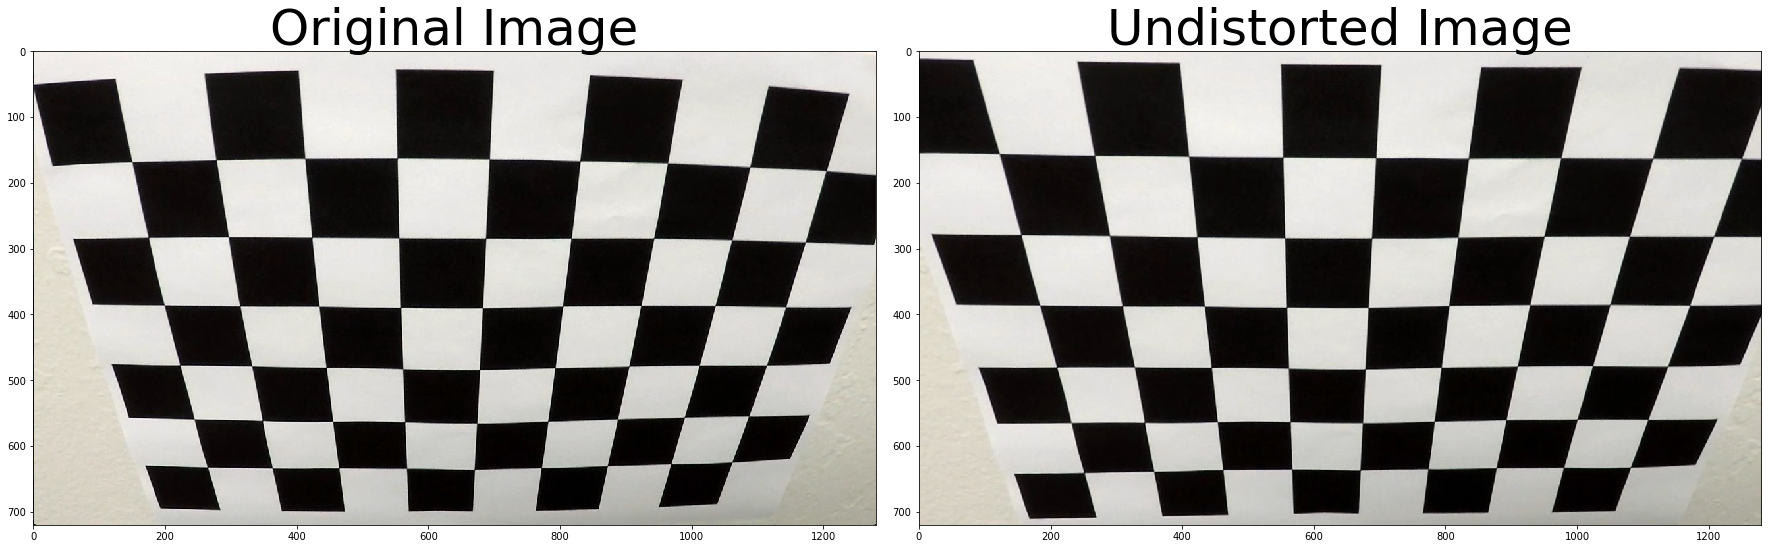

In [251]:
# Test camera calibration, image distortion correction.

img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted_img = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [252]:
# gradient threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255), binary=1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 255
    return (scaled_sobel, binary_output)[binary]

In [253]:
# gradient of gradient threshold
def mag_thresh(img, sobel_kernel=17, mag_thresh=(0, 255), binary=1):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = (abs_sobelx**2 + abs_sobely**2)**(1/2)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 255
    return (scaled_sobel, mag_binary)[binary]

In [254]:
# gradient threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 255
    return dir_binary

In [255]:
# HLS select
def hls_select(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    if channel == 'H':
        O=H
    if channel == 'L':
        O=L
    if channel == 'S':
        O=S
        thresh=(90, 255)
    binary_output = np.zeros_like(O)
    binary_output[(O > thresh[0]) & (O <= thresh[1])] = 255
    return binary_output

In [256]:
# RGB select
def rgb_select(img, channel='R', thresh=(0, 255)):
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    if channel == 'R':
        O=R
    if channel == 'G':
        O=G
    if channel == 'B':
        O=B
    binary_output = np.zeros_like(O)
    binary_output[(O > thresh[0]) & (O <= thresh[1])] = 255
    return binary_output

In [257]:
def to_binary_image(orig_image):
      # orig_img = cv2.imread('test_images/test6.jpg') # BGR
    undist_image = cal_undistort(orig_image, objpoints, imgpoints) # BGR

    # Choose a Sobel kernel size
    ksize = 1

    # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist_image, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(undist_image, orient='y', sobel_kernel=ksize, thresh=(20, 255))

    mag_binary = mag_thresh(undist_image, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(undist_image, sobel_kernel=31, thresh=(0.7, 1.1))

    H_binary = hls_select(undist_image, channel='H', thresh=(170,255))
    S_binary = hls_select(undist_image, channel='S', thresh=(200,255))
    L_binary = hls_select(undist_image, channel='L', thresh=(170,255))

    R_binary = rgb_select(undist_image, channel='R', thresh=(200,255))
    B_binary = rgb_select(undist_image, channel='G', thresh=(200,255))
    G_binary = rgb_select(undist_image, channel='B', thresh=(200,255))

    binary_result = np.zeros_like(dir_binary)
    # binary_result[((gradx == 254)) | ((gradx == 254) & (grady == 254)) | ((mag_binary == 254) & (dir_binary == 254)) | (S_binary == 254) & (R_binary == 254)] = 254
    binary_result[((mag_binary == 255) & (dir_binary == 255)) | (S_binary == 255) & (R_binary == 255)] = 255

    return binary_result

In [258]:
# load test image
orig_img = mpimg.imread('test_images/straight_lines1.jpg') # RGB
undist_img = cal_undistort(orig_img, objpoints, imgpoints) # RGB
ksize = 1
gradx = abs_sobel_thresh(undist_img, orient='x', sobel_kernel=ksize, thresh=(20, 255))
grady = abs_sobel_thresh(undist_img, orient='y', sobel_kernel=ksize, thresh=(20, 255))
mag_binary = mag_thresh(undist_img, sobel_kernel=ksize, mag_thresh=(50, 200))
dir_binary = dir_threshold(undist_img, sobel_kernel=31, thresh=(0.7, 1.1))
H_binary = hls_select(undist_img, channel='H', thresh=(170,255))
S_binary = hls_select(undist_img, channel='S', thresh=(200,255))
L_binary = hls_select(undist_img, channel='L', thresh=(170,255))
R_binary = rgb_select(undist_img, channel='R', thresh=(200,255))
B_binary = rgb_select(undist_img, channel='G', thresh=(200,255))
G_binary = rgb_select(undist_img, channel='B', thresh=(200,255))
result_out = to_binary_image(orig_img)
cv2.imwrite('output_images/combined_color_channels_gradient.jpg', result_out)


True

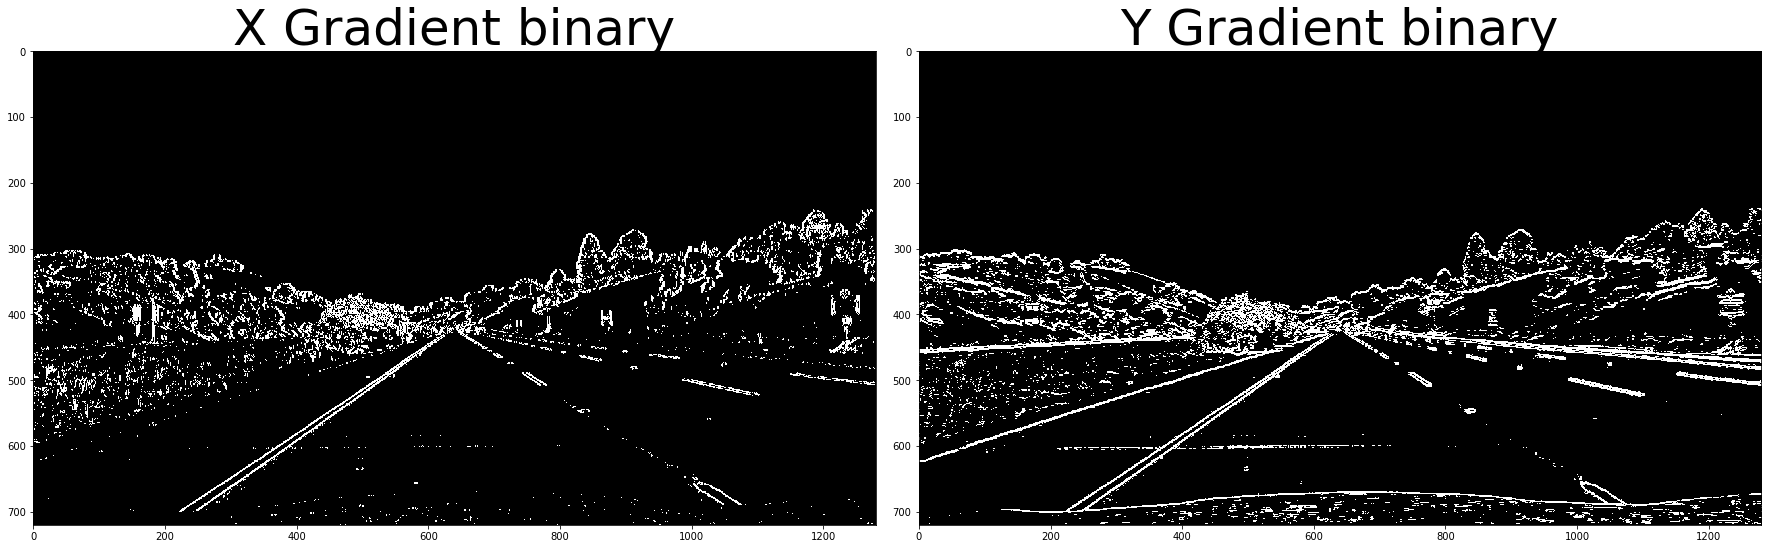

In [259]:
# Gradients
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx, cmap='gray')
ax1.set_title('X Gradient binary', fontsize=50)
ax2.imshow(grady, cmap='gray')
ax2.set_title('Y Gradient binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

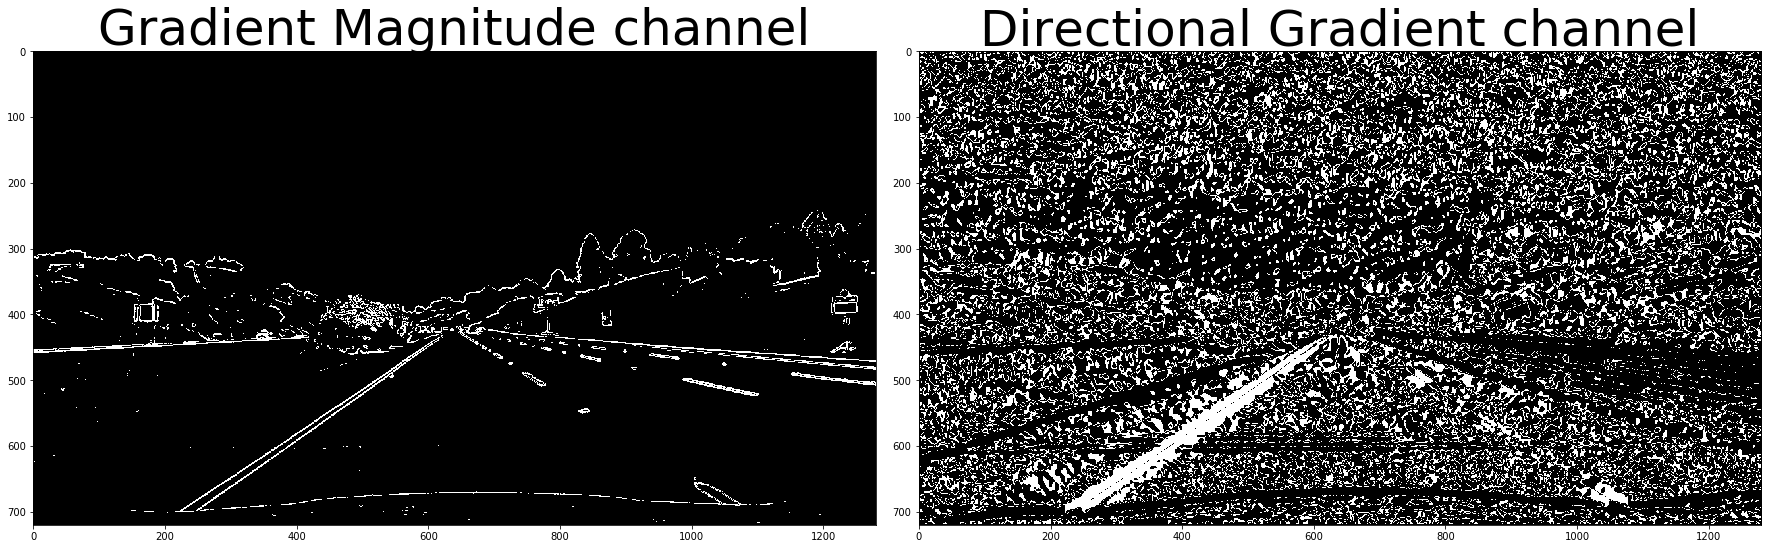

In [260]:
# Gradient Magnitude and Direction
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mag_binary, cmap='gray')
ax1.set_title('Gradient Magnitude channel', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Directional Gradient channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

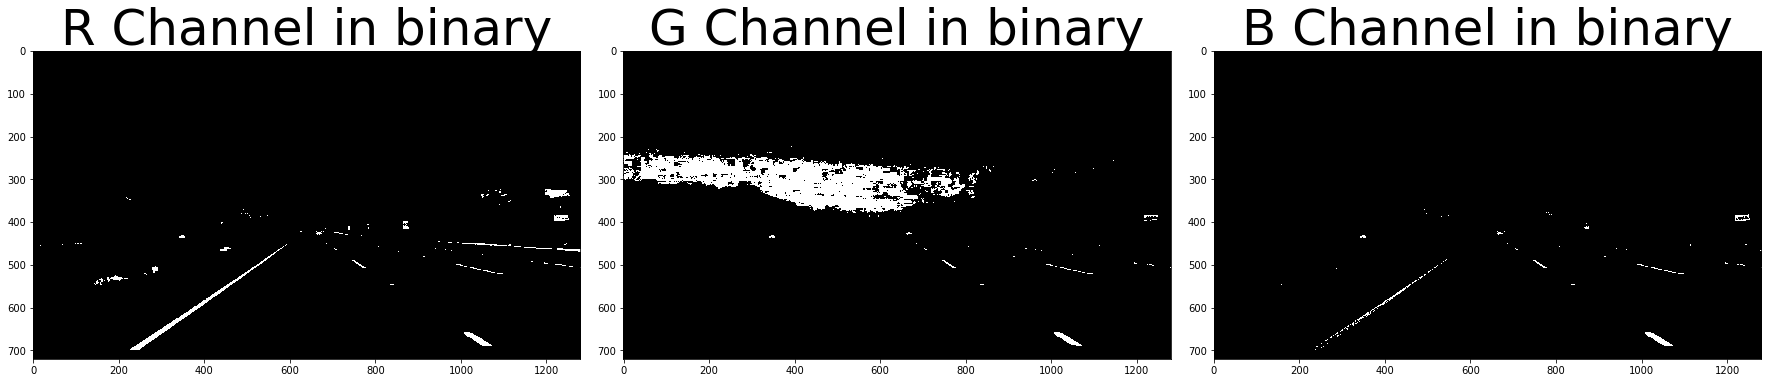

In [261]:
# Colors
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R_binary, cmap='gray')
ax1.set_title('R Channel in binary', fontsize=50)
ax2.imshow(G_binary, cmap='gray')
ax2.set_title('G Channel in binary', fontsize=50)
ax3.imshow(B_binary, cmap='gray')
ax3.set_title('B Channel in binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

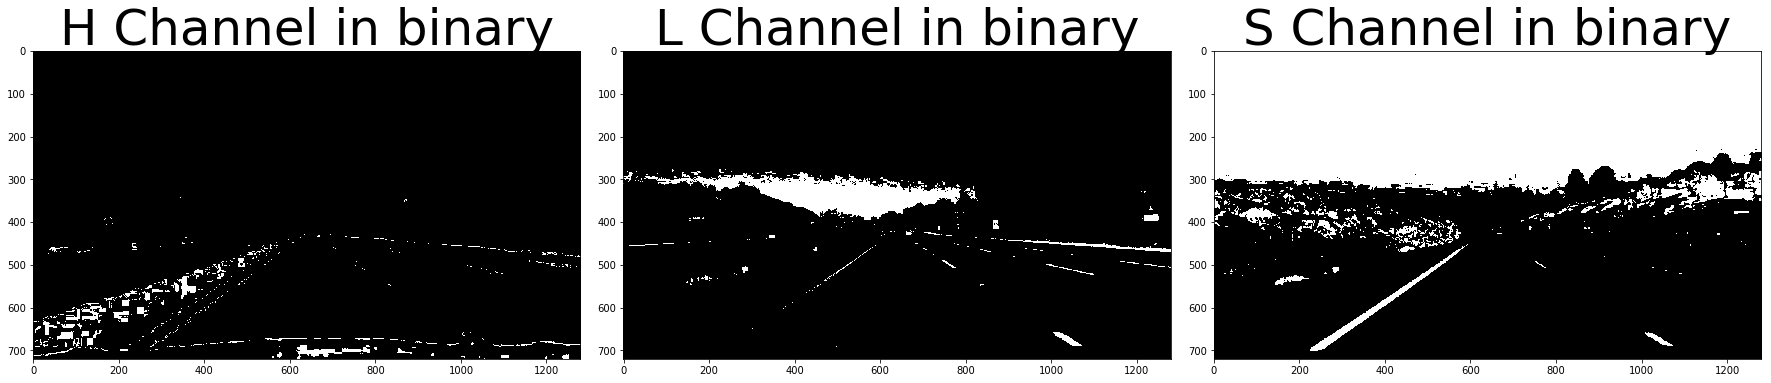

In [262]:
# HLS color map

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H_binary, cmap='gray')
ax1.set_title('H Channel in binary', fontsize=50)
ax2.imshow(L_binary, cmap='gray')
ax2.set_title('L Channel in binary', fontsize=50)
ax3.imshow(S_binary, cmap='gray')
ax3.set_title('S Channel in binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

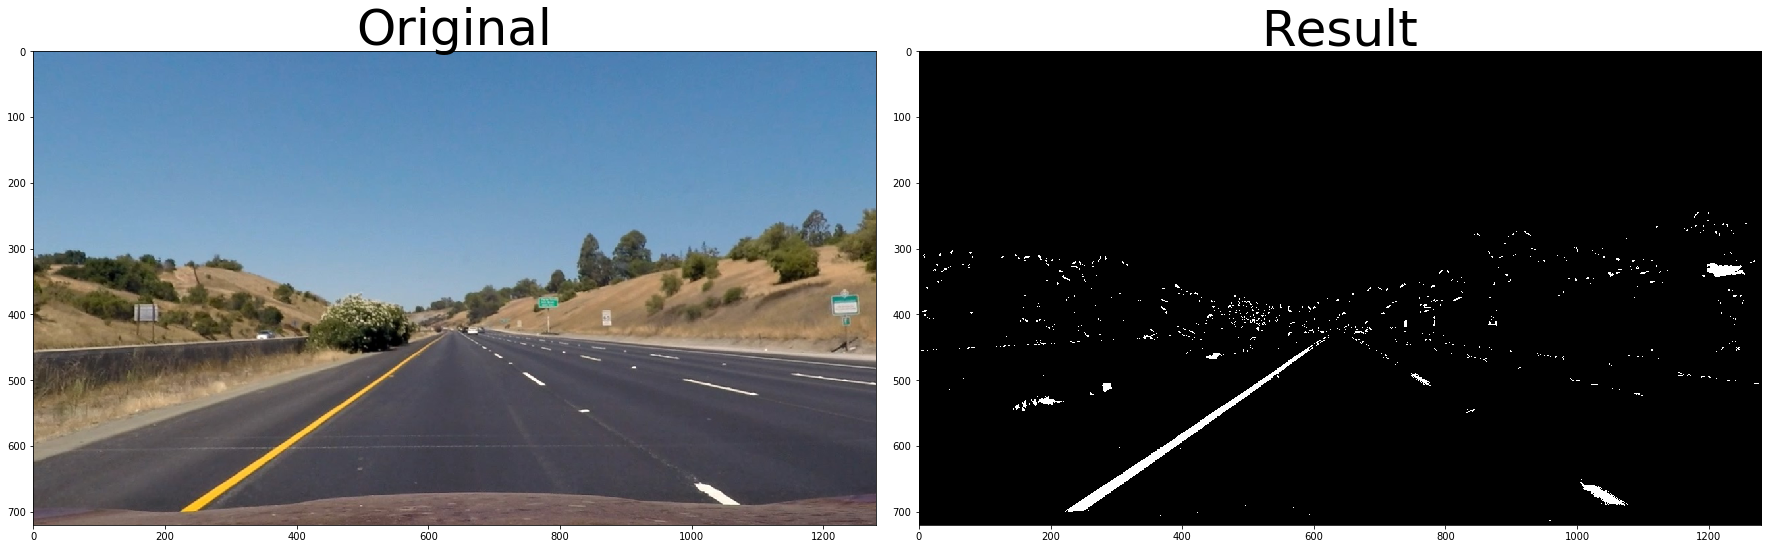

In [263]:
# Original and Combined
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist_img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(result_out, cmap='gray')
ax2.set_title('Result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [264]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [265]:
# transformation of lane line to bird-eye top view
def transform_bird_eye_view(image, src, dst):
    img_size = (image.shape[1], image.shape[0])
    src = np.float32(src) # 
    dst = np.float32(dst) #
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    birds_eye_view = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return birds_eye_view, Minv

In [266]:
src = np.float32(
    [(140,720),(570,455),(700,455),(1280,720)])
dst = np.float32(
    [(330,720),(330,0),(960,0),(960,720)])

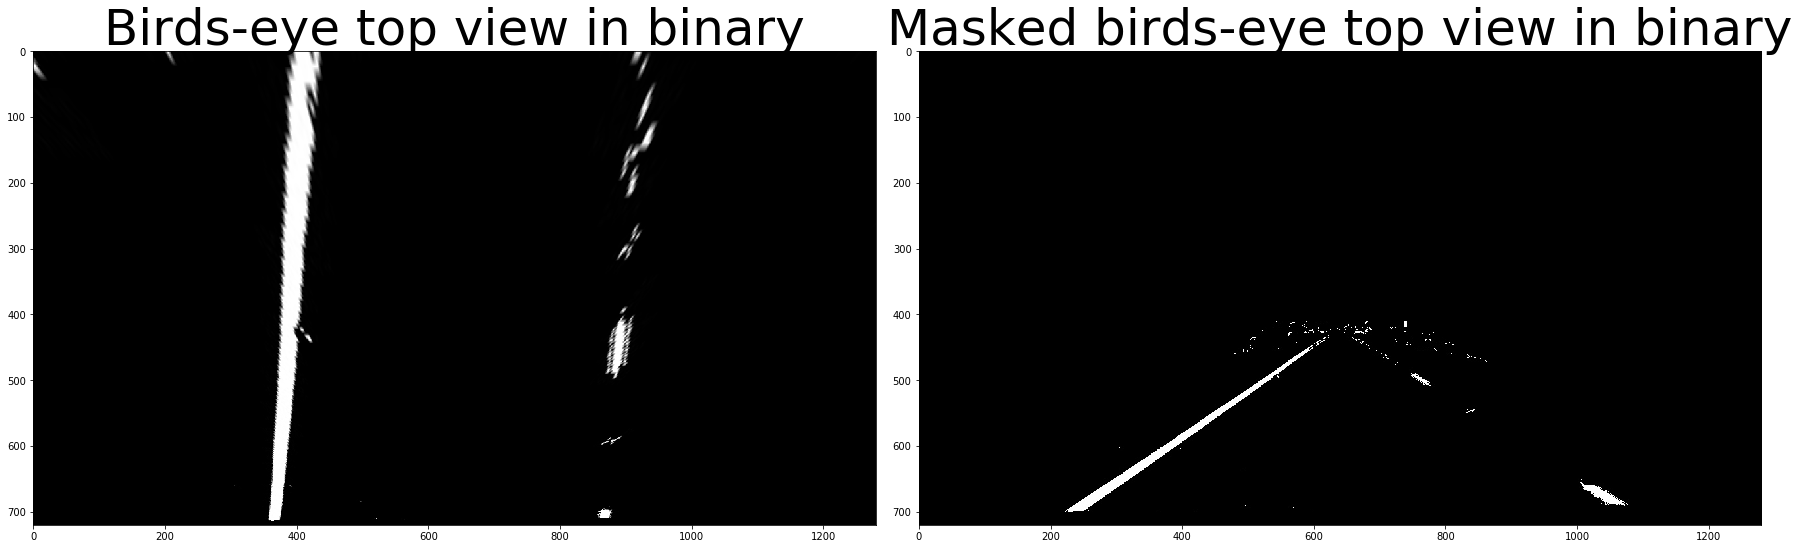

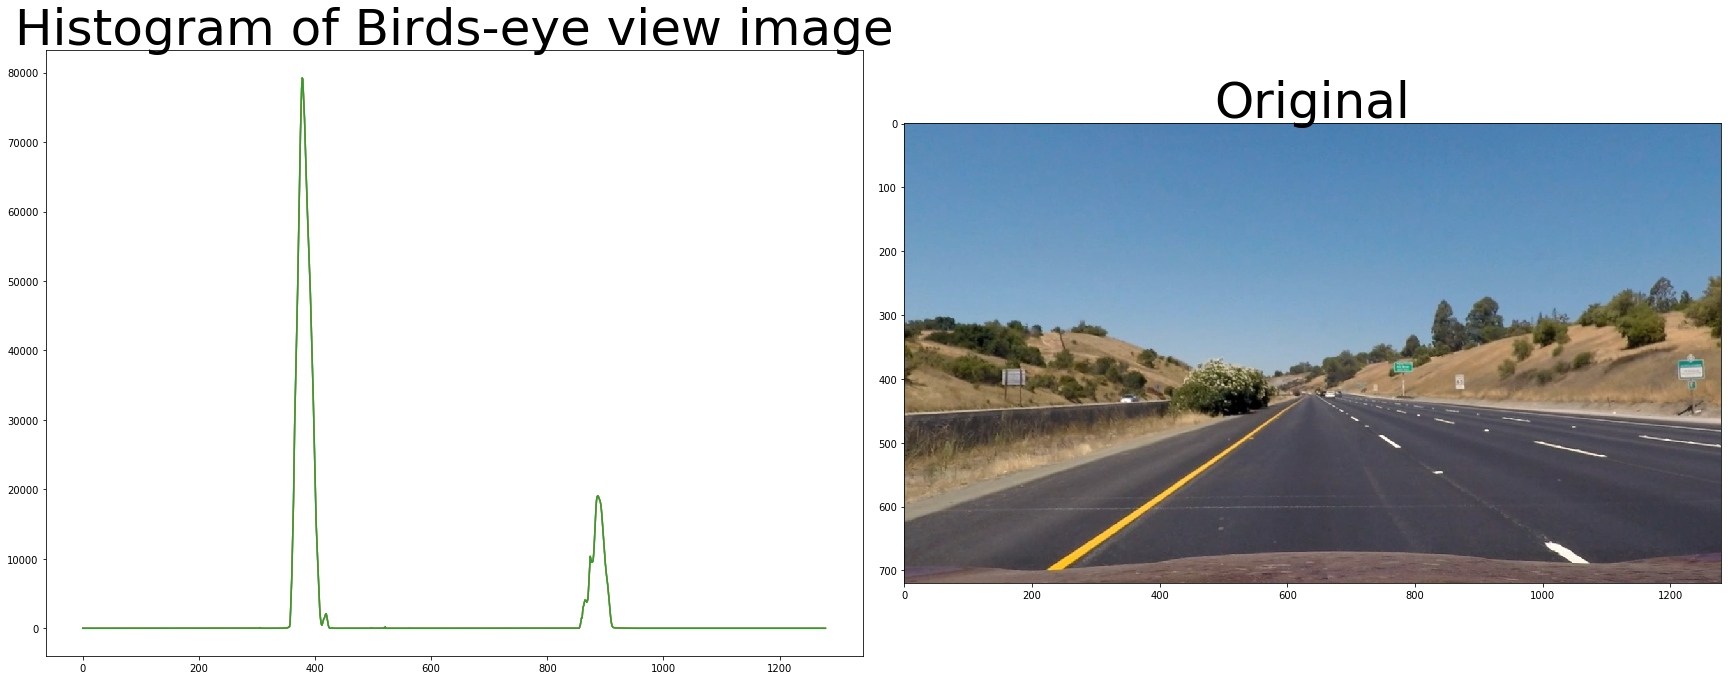

In [267]:
# Transformation of the in-car lane lines view to a birds eye view 
combined = cv2.imread('output_images/combined_color_channels_gradient.jpg')

masked_combined = region_of_interest(combined, np.int32([np.array([(140,700),(540,410),(750,410),(1280,700)])]))


binary_warped, Minv = transform_bird_eye_view(masked_combined, src, dst)

cv2.imwrite('output_images/bird-eye-top-view.jpg', binary_warped)

# Plot birds_eye_view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Birds-eye top view in binary', fontsize=50)
ax2.imshow(masked_combined, cmap='gray')
ax2.set_title('Masked birds-eye top view in binary', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.plot(histogram)
ax1.set_title('Histogram of Birds-eye view image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Original', fontsize=50)
plt.show()


In [268]:
# 
def line_search_scanning(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) # 640
    leftx_base = np.argmax(histogram[:midpoint]) # 167
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint # 984

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows) # 80 pixels
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, [left_fitx, right_fitx], [[leftx, lefty],[rightx, righty]], [left_fit, right_fit]


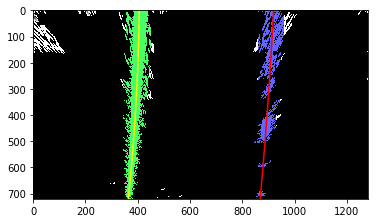

In [269]:
# # Assuming you have created a warped binary image called "binary_warped"
bird_eye_view = cv2.imread('output_images/bird-eye-top-view.jpg', 0)
ploty, fitx, xy, fit = line_search_scanning(bird_eye_view)
out_img = np.dstack((bird_eye_view, bird_eye_view, bird_eye_view))*255
out_img[xy[0][1], xy[0][0]] = [70, 255, 100]
out_img[xy[1][1], xy[1][0]] = [100, 100, 255]
plt.imshow(out_img)
plt.plot(fitx[0], ploty, color='yellow')
plt.plot(fitx[1], ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

In [270]:
def lane_curvature(ploty, fitx, xy, fit):
    
#    quadratic_coeff = 3e-4
    
    y_eval = np.max(ploty)
    
    left_fit = fitx[0]
    right_fit = fitx[1]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 24.3/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    
    leftx = xy[0][0]
    rightx = xy[1][0]

    lefty = xy[0][1]
    righty = xy[1][1]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    return left_curverad, right_curverad

In [271]:
bird_eye_view = cv2.imread('output_images/bird-eye-top-view.jpg', 0)
# fitx : line fitting
# xy : the randomn points along forming the lane
ploty, fitx, xy, fit = line_search_scanning(bird_eye_view) 

left_curverad, right_curverad = lane_curvature(ploty, fitx, xy, fit)
print(left_curverad, 'metres', right_curverad, 'metres')


1286.58909455 metres 2811.82337947 metres


In [272]:
# vehicle position
def vehicle_position(fitx):
    xm_per_pix = 3.7/500 # meters per pixel in x dimension
    
    left_x_vehicle, right_x_vehicle = fitx[0][-1], fitx[1][-1]
    # left_x_vehicle, right_x_vehicle = fitx[0].mean(), fitx[1].mean()

    # position of center lane
    x_pos_lane_center = (left_x_vehicle + right_x_vehicle) * 0.5
    
    # assuming the camera is located on the center of the vehicle so X position is:
    x_pos_camera = 1280 * 0.5
    
    vehicle_offset_from_lane_center = x_pos_lane_center - x_pos_camera
    return vehicle_offset_from_lane_center * xm_per_pix
    

In [273]:
bird_eye_view = cv2.imread('output_images/bird-eye-top-view.jpg', 0)
# fitx : line fitting
# xy : the randomn points along forming the lane
ploty, fitx, xy, fit = line_search_scanning(bird_eye_view) 

vehicle_offset_from_center_lane_metres = vehicle_position(fitx)

print(vehicle_offset_from_center_lane_metres, 'm')

364.519184523 868.375114478
-0.174291093698 m


In [274]:
def lane_augmentation(binary_warped, ploty, fitx, Minv, original_img):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([fitx[0], ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fitx[1], ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
    return result

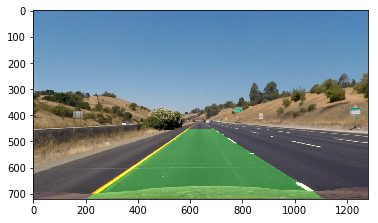

In [275]:
# Create the original image to draw the lines on
result = lane_augmentation(bird_eye_view, ploty, fitx, Minv, cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
    
plt.imshow(result)
plt.show()

In [276]:
def lane_width(lane_xy_pixels):
    left_lane_avg_x, left_lane_avg_y = lane_xy_pixels[0][0].mean(), lane_xy_pixels[0][1].mean()
    right_lane_avg_x, right_lane_avg_y = lane_xy_pixels[1][0].mean(), lane_xy_pixels[1][1].mean()
    return (( (left_lane_avg_x - right_lane_avg_x)**2 + (left_lane_avg_y - right_lane_avg_y)**2 )**(1/2)) * 3.7 / 500
     

In [277]:
avg_width = lane_width(xy)
print(avg_width, 'm')

3.81768062823 m


In [278]:
def process_image(orig_image):

    binary_result = to_binary_image(orig_image)
    
    # masking road
    masked_combined = region_of_interest(binary_result, np.int32([np.array([(140,700),(540,410),(750,410),(1280,700)])]))
    
    # bird-eyes view
    binary_warped_image, M_inv = transform_bird_eye_view(masked_combined, src, dst)
    
    ploty, fitx, xy, fit = line_search_scanning(binary_warped_image)
    
    # curvature
    left_lane_cur, right_lane_cur = lane_curvature(ploty, fitx, xy, fit)
    
    result = lane_augmentation(binary_warped_image, ploty, fitx, M_inv, cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
    
    # add curvature to video stream
    cv2.putText(result,"Curvature left: {0:.{1}f} m".format(left_lane_cur,2), (2,40), cv2.FONT_HERSHEY_SIMPLEX, 1,0)
    cv2.putText(result,"Curvature right : {0:.{1}f} m".format(right_lane_cur,2), (2,80), cv2.FONT_HERSHEY_SIMPLEX, 1,0)
    cv2.putText(result,"Lane width : {0:.{1}f} m".format(lane_width(xy),2), (2,120), cv2.FONT_HERSHEY_SIMPLEX, 1,0)
    cv2.putText(result,"Vehicle offset from centre : {0:.{1}f} m".format(vehicle_position(fitx),2), (2,160), cv2.FONT_HERSHEY_SIMPLEX, 1,0)

    return result

In [279]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import shutil

white_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")#.subclip(20,30)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

408.629969905 911.960915963
[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


  0%|          | 1/1261 [00:00<05:54,  3.55it/s]

408.629969905 911.960915963


  0%|          | 2/1261 [00:00<06:10,  3.40it/s]

409.574929174 915.356191316


  0%|          | 3/1261 [00:00<06:06,  3.43it/s]

409.947154256 920.601724041


  0%|          | 4/1261 [00:01<06:03,  3.46it/s]

410.723182055 921.919307886


  0%|          | 5/1261 [00:01<05:53,  3.55it/s]

411.624563782 922.895901218


  0%|          | 6/1261 [00:01<05:57,  3.51it/s]

412.88258349 923.599542245


  1%|          | 7/1261 [00:02<05:52,  3.56it/s]

414.011746757 923.424413779


  1%|          | 8/1261 [00:02<05:48,  3.60it/s]

415.818104337 921.557981834


  1%|          | 9/1261 [00:02<05:42,  3.66it/s]

416.178127615 922.196009704


  1%|          | 10/1261 [00:02<05:40,  3.67it/s]

417.162183828 931.060039735


  1%|          | 11/1261 [00:03<05:40,  3.67it/s]

417.115583328 925.628357742


  1%|          | 12/1261 [00:03<05:35,  3.72it/s]

416.506086498 919.128467745


  1%|          | 13/1261 [00:03<05:33,  3.75it/s]

417.43756821 918.693763762


  1%|          | 14/1261 [00:03<05:32,  3.75it/s]

417.575083395 920.235375184


  1%|          | 15/1261 [00:04<05:30,  3.77it/s]

418.6481589 920.858999034


  1%|▏         | 16/1261 [00:04<05:27,  3.80it/s]

418.378613973 918.491486811


  1%|▏         | 17/1261 [00:04<05:25,  3.82it/s]

417.379278731 917.013442122


  1%|▏         | 18/1261 [00:04<05:24,  3.83it/s]

416.701872321 914.365846225


  2%|▏         | 19/1261 [00:05<05:23,  3.83it/s]

415.876154009 915.579496601


  2%|▏         | 20/1261 [00:05<05:25,  3.81it/s]

414.753501433 911.952850278


  2%|▏         | 21/1261 [00:05<05:24,  3.82it/s]

413.159595809 893.135943739


  2%|▏         | 22/1261 [00:05<05:22,  3.84it/s]

411.714841474 903.849664201


  2%|▏         | 23/1261 [00:06<05:23,  3.82it/s]

409.757765424 898.217553504


  2%|▏         | 24/1261 [00:06<05:26,  3.79it/s]

408.29530767 913.439144867


  2%|▏         | 25/1261 [00:06<05:25,  3.80it/s]

406.811705366 905.145100216


  2%|▏         | 26/1261 [00:07<05:23,  3.81it/s]

404.980382181 902.434722975


  2%|▏         | 27/1261 [00:07<05:19,  3.86it/s]

403.173966669 907.108321942


  2%|▏         | 28/1261 [00:07<05:18,  3.87it/s]

400.929857436 912.30418662


  2%|▏         | 29/1261 [00:07<05:17,  3.87it/s]

398.919335815 913.86651741


  2%|▏         | 30/1261 [00:08<05:17,  3.87it/s]

398.5273991 914.453628709


  2%|▏         | 31/1261 [00:08<05:18,  3.87it/s]

398.669440341 916.118101316


  3%|▎         | 32/1261 [00:08<05:18,  3.86it/s]

399.036016092 912.61274124


  3%|▎         | 33/1261 [00:08<05:16,  3.88it/s]

399.013179805 914.960522496


  3%|▎         | 34/1261 [00:09<05:17,  3.86it/s]

399.408935282 908.971894404


  3%|▎         | 35/1261 [00:09<05:16,  3.87it/s]

399.95266309 930.217354559


  3%|▎         | 36/1261 [00:09<05:17,  3.86it/s]

401.324625416 907.899080166


  3%|▎         | 37/1261 [00:09<05:16,  3.87it/s]

402.085421515 901.507504098


  3%|▎         | 38/1261 [00:10<05:16,  3.87it/s]

402.834003164 907.82094048


  3%|▎         | 39/1261 [00:10<05:15,  3.87it/s]

403.499277496 914.360994275


  3%|▎         | 40/1261 [00:10<05:17,  3.84it/s]

404.382807427 913.86941329


  3%|▎         | 41/1261 [00:10<05:18,  3.83it/s]

405.246574901 911.653930513


  3%|▎         | 42/1261 [00:11<05:18,  3.83it/s]

406.884065595 913.925983467


  3%|▎         | 43/1261 [00:11<05:20,  3.80it/s]

407.448656595 915.654211226


  3%|▎         | 44/1261 [00:11<05:19,  3.81it/s]

407.803799621 916.315047242


  4%|▎         | 45/1261 [00:11<05:20,  3.79it/s]

408.480968317 917.123134296


  4%|▎         | 46/1261 [00:12<05:17,  3.83it/s]

408.775706772 908.163155463


  4%|▎         | 47/1261 [00:12<05:19,  3.80it/s]

409.3118395 900.778005955


  4%|▍         | 48/1261 [00:12<05:20,  3.78it/s]

410.467566452 921.837935232


  4%|▍         | 49/1261 [00:13<05:23,  3.75it/s]

410.282757952 927.967793786


  4%|▍         | 50/1261 [00:13<05:21,  3.76it/s]

411.637413257 911.138864944


  4%|▍         | 51/1261 [00:13<05:21,  3.77it/s]

412.157985382 909.613258951


  4%|▍         | 52/1261 [00:13<05:20,  3.78it/s]

413.439674194 911.315573989


  4%|▍         | 53/1261 [00:14<05:20,  3.77it/s]

413.814226626 912.981657292


  4%|▍         | 54/1261 [00:14<05:20,  3.77it/s]

413.923950317 913.99825132


  4%|▍         | 55/1261 [00:14<05:21,  3.75it/s]

413.475714551 914.146327352


  4%|▍         | 56/1261 [00:14<05:23,  3.72it/s]

411.962958292 914.983217319


  5%|▍         | 57/1261 [00:15<05:21,  3.74it/s]

410.59897218 912.785205643


  5%|▍         | 58/1261 [00:15<05:21,  3.75it/s]

409.125436558 912.110715901


  5%|▍         | 59/1261 [00:15<05:23,  3.72it/s]

407.912412623 922.408145


  5%|▍         | 60/1261 [00:15<05:23,  3.72it/s]

407.048713037 929.575008728


  5%|▍         | 61/1261 [00:16<05:28,  3.66it/s]

405.616839492 903.803619668


  5%|▍         | 62/1261 [00:16<05:27,  3.66it/s]

405.561803841 906.791811623


  5%|▍         | 63/1261 [00:16<05:28,  3.65it/s]

404.196911164 906.182283215


  5%|▌         | 64/1261 [00:17<05:30,  3.62it/s]

403.335540661 909.805637121


  5%|▌         | 65/1261 [00:17<05:25,  3.68it/s]

400.793639955 906.833926362


  5%|▌         | 66/1261 [00:17<05:21,  3.71it/s]

400.904729578 904.984419774


  5%|▌         | 67/1261 [00:17<05:16,  3.77it/s]

400.759702132 904.533452745


  5%|▌         | 68/1261 [00:18<05:13,  3.81it/s]

399.959123936 901.202913223


  5%|▌         | 69/1261 [00:18<05:11,  3.83it/s]

399.666615868 901.746807819


  6%|▌         | 70/1261 [00:18<05:10,  3.84it/s]

398.875440201 896.782079692


  6%|▌         | 71/1261 [00:18<05:08,  3.85it/s]

399.228435818 894.071242097


  6%|▌         | 72/1261 [00:19<05:07,  3.86it/s]

399.279340149 901.98589376


  6%|▌         | 73/1261 [00:19<05:08,  3.85it/s]

399.694774767 882.611715036


  6%|▌         | 74/1261 [00:19<05:08,  3.85it/s]

399.599068942 880.769579162


  6%|▌         | 75/1261 [00:19<05:08,  3.84it/s]

398.325002952 884.137394593


  6%|▌         | 76/1261 [00:20<05:08,  3.84it/s]

399.025898111 890.505536426


  6%|▌         | 77/1261 [00:20<05:10,  3.81it/s]

396.54081447 892.233693678


  6%|▌         | 78/1261 [00:20<05:10,  3.81it/s]

395.714551048 893.420398304


  6%|▋         | 79/1261 [00:20<05:07,  3.85it/s]

393.732932218 896.112937024


  6%|▋         | 80/1261 [00:21<05:07,  3.85it/s]

391.534748843 895.958488057


  6%|▋         | 81/1261 [00:21<05:08,  3.82it/s]

390.687712273 897.087116372


  7%|▋         | 82/1261 [00:21<05:06,  3.85it/s]

387.833787805 895.136317393


  7%|▋         | 83/1261 [00:21<05:04,  3.86it/s]

385.841520345 895.158396837


  7%|▋         | 84/1261 [00:22<05:11,  3.78it/s]

383.468477832 896.29838582


  7%|▋         | 85/1261 [00:22<05:10,  3.79it/s]

381.437096144 897.122461983


  7%|▋         | 86/1261 [00:22<05:10,  3.79it/s]

380.774925665 902.712407381


  7%|▋         | 87/1261 [00:23<05:10,  3.78it/s]

381.056414075 893.36928689


  7%|▋         | 88/1261 [00:23<05:08,  3.80it/s]

381.141460456 889.275744079


  7%|▋         | 89/1261 [00:23<05:09,  3.79it/s]

381.670227451 893.625648185


  7%|▋         | 90/1261 [00:23<05:10,  3.77it/s]

383.335774165 896.392032903


  7%|▋         | 91/1261 [00:24<05:16,  3.70it/s]

382.199727136 896.226385542


  7%|▋         | 92/1261 [00:24<05:12,  3.74it/s]

383.88951224 895.69713703


  7%|▋         | 93/1261 [00:24<05:11,  3.75it/s]

383.648351699 893.181377808


  7%|▋         | 94/1261 [00:24<05:14,  3.71it/s]

385.473940816 891.092947802


  8%|▊         | 95/1261 [00:25<05:11,  3.74it/s]

385.31481339 888.937151708


  8%|▊         | 96/1261 [00:25<05:15,  3.69it/s]

386.152537196 879.992291816


  8%|▊         | 97/1261 [00:25<05:11,  3.74it/s]

387.486170064 900.066407351


  8%|▊         | 98/1261 [00:26<05:10,  3.74it/s]

387.540071774 883.474817965


  8%|▊         | 99/1261 [00:26<05:07,  3.78it/s]

389.29159253 877.398738144


  8%|▊         | 100/1261 [00:26<05:04,  3.81it/s]

390.334209562 882.542739631


  8%|▊         | 101/1261 [00:26<05:02,  3.83it/s]

391.16997711 883.380173527


  8%|▊         | 102/1261 [00:27<05:00,  3.85it/s]

391.974372247 886.239601983


  8%|▊         | 103/1261 [00:27<04:59,  3.86it/s]

391.621362906 890.43396475


  8%|▊         | 104/1261 [00:27<05:01,  3.84it/s]

391.86428974 891.296391256


  8%|▊         | 105/1261 [00:27<04:58,  3.87it/s]

391.883395552 894.271393511


  8%|▊         | 106/1261 [00:28<04:59,  3.86it/s]

391.67121084 895.688200408


  8%|▊         | 107/1261 [00:28<05:00,  3.84it/s]

392.31793918 898.497770711


  9%|▊         | 108/1261 [00:28<04:58,  3.86it/s]

392.828393401 894.518371651


  9%|▊         | 109/1261 [00:28<04:56,  3.88it/s]

393.067651421 881.396115559


  9%|▊         | 110/1261 [00:29<04:57,  3.87it/s]

393.197605333 885.573077375


  9%|▉         | 111/1261 [00:29<04:55,  3.89it/s]

393.953457046 904.476885845


  9%|▉         | 112/1261 [00:29<04:56,  3.87it/s]

394.540924757 900.341396677


  9%|▉         | 113/1261 [00:29<04:57,  3.86it/s]

395.867072534 894.21302882


  9%|▉         | 114/1261 [00:30<04:59,  3.84it/s]

396.794161967 892.237552657


  9%|▉         | 115/1261 [00:30<04:57,  3.85it/s]

397.744567051 896.468359468


  9%|▉         | 116/1261 [00:30<04:56,  3.86it/s]

397.763705859 901.724630855


  9%|▉         | 117/1261 [00:30<05:02,  3.78it/s]

397.69627156 901.924426322


  9%|▉         | 118/1261 [00:31<05:02,  3.78it/s]

398.220718042 902.7914589


  9%|▉         | 119/1261 [00:31<05:01,  3.79it/s]

398.621203744 903.209915598


 10%|▉         | 120/1261 [00:31<04:58,  3.82it/s]

399.949513807 901.592564264


 10%|▉         | 121/1261 [00:31<04:58,  3.82it/s]

401.268816621 902.63338936


 10%|▉         | 122/1261 [00:32<04:56,  3.84it/s]

402.817285815 907.9690138


 10%|▉         | 123/1261 [00:32<04:55,  3.85it/s]

403.626022967 893.044219232


 10%|▉         | 124/1261 [00:32<04:52,  3.88it/s]

404.748849124 895.227772261


 10%|▉         | 125/1261 [00:33<04:53,  3.87it/s]

406.070864371 902.863065376


 10%|▉         | 126/1261 [00:33<04:52,  3.88it/s]

406.605231582 903.151757572


 10%|█         | 127/1261 [00:33<04:52,  3.88it/s]

407.80462642 912.014941944


 10%|█         | 128/1261 [00:33<04:53,  3.86it/s]

408.505315625 911.044387813


 10%|█         | 129/1261 [00:34<04:53,  3.86it/s]

410.031101176 911.728663379


 10%|█         | 130/1261 [00:34<04:54,  3.84it/s]

410.520699231 910.142879322


 10%|█         | 131/1261 [00:34<04:53,  3.85it/s]

411.322965254 909.035813419


 10%|█         | 132/1261 [00:34<04:52,  3.86it/s]

412.504488026 907.836299089


 11%|█         | 133/1261 [00:35<04:55,  3.82it/s]

413.039648497 911.058835896


 11%|█         | 134/1261 [00:35<04:53,  3.84it/s]

413.664801662 897.007894781


 11%|█         | 135/1261 [00:35<04:51,  3.86it/s]

414.555998222 902.098274873


 11%|█         | 136/1261 [00:35<04:49,  3.88it/s]

415.438781156 901.414051116


 11%|█         | 137/1261 [00:36<04:51,  3.86it/s]

415.672083395 902.744908209


 11%|█         | 138/1261 [00:36<04:50,  3.87it/s]

414.518934473 906.446891898


 11%|█         | 139/1261 [00:36<04:52,  3.83it/s]

413.509990021 911.483007056


 11%|█         | 140/1261 [00:36<04:56,  3.78it/s]

412.393632754 912.164012847


 11%|█         | 141/1261 [00:37<04:55,  3.79it/s]

411.388337569 917.177392711


 11%|█▏        | 142/1261 [00:37<04:55,  3.78it/s]

411.081667265 916.986668604


 11%|█▏        | 143/1261 [00:37<04:54,  3.80it/s]

411.940252115 917.626518482


 11%|█▏        | 144/1261 [00:37<04:53,  3.81it/s]

411.903470588 913.244615584


 11%|█▏        | 145/1261 [00:38<04:52,  3.81it/s]

410.108101765 912.988094174


 12%|█▏        | 146/1261 [00:38<04:52,  3.82it/s]

410.025321803 912.967396603


 12%|█▏        | 147/1261 [00:38<04:51,  3.83it/s]

410.279539833 916.158955879


 12%|█▏        | 148/1261 [00:39<04:49,  3.84it/s]

411.423798646 899.656090333


 12%|█▏        | 149/1261 [00:39<04:50,  3.83it/s]

411.141256832 903.076032763


 12%|█▏        | 150/1261 [00:39<04:48,  3.85it/s]

411.651714654 904.155490724


 12%|█▏        | 151/1261 [00:39<04:48,  3.85it/s]

411.424613553 906.663170348


 12%|█▏        | 152/1261 [00:40<04:46,  3.87it/s]

410.24685308 908.966642558


 12%|█▏        | 153/1261 [00:40<04:46,  3.87it/s]

409.928685371 911.399072857


 12%|█▏        | 154/1261 [00:40<04:44,  3.89it/s]

408.506143697 913.204261123


 12%|█▏        | 155/1261 [00:40<04:44,  3.89it/s]

406.693044979 913.091346833


 12%|█▏        | 156/1261 [00:41<04:43,  3.89it/s]

405.586591507 913.831096477


 12%|█▏        | 157/1261 [00:41<04:45,  3.87it/s]

404.547026575 912.33154757


 13%|█▎        | 158/1261 [00:41<04:47,  3.84it/s]

403.570325006 909.951202896


 13%|█▎        | 159/1261 [00:41<04:52,  3.77it/s]

401.847832756 930.066062839


 13%|█▎        | 160/1261 [00:42<04:58,  3.68it/s]

401.327123032 910.221089697


 13%|█▎        | 161/1261 [00:42<05:00,  3.66it/s]

400.404998572 902.801249138


 13%|█▎        | 162/1261 [00:42<05:01,  3.64it/s]

400.329293624 911.046030817


 13%|█▎        | 163/1261 [00:42<05:01,  3.65it/s]

399.90289116 908.123417703


 13%|█▎        | 164/1261 [00:43<05:01,  3.64it/s]

400.418620578 910.975304572


 13%|█▎        | 165/1261 [00:43<05:00,  3.65it/s]

401.093793189 912.619478268


 13%|█▎        | 166/1261 [00:43<04:56,  3.69it/s]

400.248927635 911.450801387


 13%|█▎        | 167/1261 [00:44<04:54,  3.71it/s]

400.463336208 908.815379422


 13%|█▎        | 168/1261 [00:44<04:53,  3.72it/s]

400.056820314 909.750605766


 13%|█▎        | 169/1261 [00:44<04:58,  3.66it/s]

400.07155952 908.462386543


 13%|█▎        | 170/1261 [00:44<04:57,  3.67it/s]

398.342308624 906.33059592


 14%|█▎        | 171/1261 [00:45<04:54,  3.70it/s]

398.177184912 896.27970851


 14%|█▎        | 172/1261 [00:45<04:56,  3.67it/s]

397.291436137 886.568749034


 14%|█▎        | 173/1261 [00:45<04:55,  3.68it/s]

396.387739759 875.022979532


 14%|█▍        | 174/1261 [00:45<04:56,  3.67it/s]

395.926356948 883.477872556


 14%|█▍        | 175/1261 [00:46<04:56,  3.66it/s]

394.909509027 895.397313692


 14%|█▍        | 176/1261 [00:46<04:55,  3.67it/s]

393.382111945 896.009159264


 14%|█▍        | 177/1261 [00:46<04:59,  3.62it/s]

391.883581458 894.722384284


 14%|█▍        | 178/1261 [00:47<04:57,  3.64it/s]

390.70094868 899.683086263


 14%|█▍        | 179/1261 [00:47<04:58,  3.62it/s]

390.72049493 901.480300856


 14%|█▍        | 180/1261 [00:47<04:57,  3.63it/s]

388.807319296 904.842508927


 14%|█▍        | 181/1261 [00:47<04:58,  3.62it/s]

388.014188795 904.367130754


 14%|█▍        | 182/1261 [00:48<04:59,  3.60it/s]

385.827242197 907.827662199


 15%|█▍        | 183/1261 [00:48<04:57,  3.63it/s]

384.962236814 909.556614067


 15%|█▍        | 184/1261 [00:48<04:57,  3.63it/s]

384.992782878 922.902270028


 15%|█▍        | 185/1261 [00:49<04:52,  3.68it/s]

385.689967383 899.894213108


 15%|█▍        | 186/1261 [00:49<04:56,  3.63it/s]

387.051780148 912.637627671


 15%|█▍        | 187/1261 [00:49<05:00,  3.57it/s]

388.262258852 914.617933549


 15%|█▍        | 188/1261 [00:49<04:58,  3.60it/s]

390.426144411 922.161263761


 15%|█▍        | 189/1261 [00:50<04:58,  3.59it/s]

392.534423187 915.16427676


 15%|█▌        | 190/1261 [00:50<04:57,  3.60it/s]

394.998916139 915.790266712


 15%|█▌        | 191/1261 [00:50<04:56,  3.61it/s]

397.184110457 910.664658692


 15%|█▌        | 192/1261 [00:50<04:55,  3.61it/s]

398.097482388 909.233256071


 15%|█▌        | 193/1261 [00:51<04:56,  3.61it/s]

400.478606852 908.802856261


 15%|█▌        | 194/1261 [00:51<04:53,  3.63it/s]

402.269194275 908.863414735


 15%|█▌        | 195/1261 [00:51<04:55,  3.61it/s]

402.47828141 902.299791175


 16%|█▌        | 196/1261 [00:52<04:56,  3.60it/s]

402.670294977 916.043109741


 16%|█▌        | 197/1261 [00:52<04:59,  3.55it/s]

401.572505686 907.857689108


 16%|█▌        | 198/1261 [00:52<04:58,  3.56it/s]

400.19798958 901.675636121


 16%|█▌        | 199/1261 [00:52<04:56,  3.58it/s]

399.006930117 907.552056947


 16%|█▌        | 200/1261 [00:53<04:56,  3.58it/s]

398.74579723 917.525557659


 16%|█▌        | 201/1261 [00:53<04:52,  3.62it/s]

395.963276018 912.319093901


 16%|█▌        | 202/1261 [00:53<04:46,  3.70it/s]

394.04486513 908.499202576


 16%|█▌        | 203/1261 [00:53<04:44,  3.72it/s]

393.551739438 908.836992925


 16%|█▌        | 204/1261 [00:54<04:40,  3.77it/s]

391.429098073 910.909023769


 16%|█▋        | 205/1261 [00:54<04:37,  3.81it/s]

391.983514632 909.925528781


 16%|█▋        | 206/1261 [00:54<04:35,  3.83it/s]

392.612045321 909.936920959


 16%|█▋        | 207/1261 [00:55<04:35,  3.82it/s]

393.154161571 906.481222304


 16%|█▋        | 208/1261 [00:55<04:34,  3.84it/s]

393.047357935 901.326331903


 17%|█▋        | 209/1261 [00:55<04:33,  3.84it/s]

393.71400622 896.85204859


 17%|█▋        | 210/1261 [00:55<04:33,  3.85it/s]

393.70858311 904.082078997


 17%|█▋        | 211/1261 [00:56<04:35,  3.82it/s]

393.605805636 909.898411315


 17%|█▋        | 212/1261 [00:56<04:34,  3.82it/s]

394.113264194 909.587411876


 17%|█▋        | 213/1261 [00:56<04:33,  3.83it/s]

392.952334145 906.42188215


 17%|█▋        | 214/1261 [00:56<04:34,  3.81it/s]

392.684252454 908.541485388


 17%|█▋        | 215/1261 [00:57<04:33,  3.83it/s]

391.426031597 909.374033671


 17%|█▋        | 216/1261 [00:57<04:34,  3.81it/s]

391.377760148 908.280889658


 17%|█▋        | 217/1261 [00:57<04:33,  3.82it/s]

391.537047621 906.382801432


 17%|█▋        | 218/1261 [00:57<04:32,  3.83it/s]

391.452076935 906.672442329


 17%|█▋        | 219/1261 [00:58<04:30,  3.85it/s]

392.50962726 901.845283712


 17%|█▋        | 220/1261 [00:58<04:29,  3.86it/s]

392.7312635 900.751505235


 18%|█▊        | 221/1261 [00:58<04:28,  3.87it/s]

393.230989889 894.543849882


 18%|█▊        | 222/1261 [00:58<04:28,  3.87it/s]

393.414815228 903.584390386


 18%|█▊        | 223/1261 [00:59<04:28,  3.87it/s]

394.094514332 904.520222341


 18%|█▊        | 224/1261 [00:59<04:27,  3.88it/s]

395.084506962 892.201802541


 18%|█▊        | 225/1261 [00:59<04:27,  3.88it/s]

394.191460077 893.947154943


 18%|█▊        | 226/1261 [00:59<04:29,  3.84it/s]

394.293615764 898.136889352


 18%|█▊        | 227/1261 [01:00<04:31,  3.81it/s]

393.243262995 896.523271189


 18%|█▊        | 228/1261 [01:00<04:29,  3.83it/s]

391.482948005 896.880877569


 18%|█▊        | 229/1261 [01:00<04:32,  3.78it/s]

390.253579637 894.320432776


 18%|█▊        | 230/1261 [01:01<04:34,  3.75it/s]

388.525706952 893.571312344


 18%|█▊        | 231/1261 [01:01<04:33,  3.77it/s]

387.762174333 889.722875386


 18%|█▊        | 232/1261 [01:01<04:32,  3.78it/s]

386.018798021 892.552495439


 18%|█▊        | 233/1261 [01:01<04:30,  3.80it/s]

385.399574371 882.1261351


 19%|█▊        | 234/1261 [01:02<04:31,  3.79it/s]

384.266414143 891.526696173


 19%|█▊        | 235/1261 [01:02<04:30,  3.79it/s]

382.567514701 879.05190412


 19%|█▊        | 236/1261 [01:02<04:29,  3.80it/s]

381.476283274 874.240959707


 19%|█▉        | 237/1261 [01:02<04:28,  3.82it/s]

379.967302141 879.267791173


 19%|█▉        | 238/1261 [01:03<04:27,  3.83it/s]

378.52777117 882.895850948


 19%|█▉        | 239/1261 [01:03<04:27,  3.83it/s]

377.33366877 884.671966993


 19%|█▉        | 240/1261 [01:03<04:25,  3.84it/s]

376.084890213 885.677003394


 19%|█▉        | 241/1261 [01:03<04:25,  3.84it/s]

375.194084961 884.178757636


 19%|█▉        | 242/1261 [01:04<04:25,  3.84it/s]

373.383158745 883.377587536


 19%|█▉        | 243/1261 [01:04<04:25,  3.84it/s]

373.748504112 882.323012692


 19%|█▉        | 244/1261 [01:04<04:24,  3.84it/s]

373.025983759 880.575229066


 19%|█▉        | 245/1261 [01:04<04:23,  3.85it/s]

373.261547329 893.423215399


 20%|█▉        | 246/1261 [01:05<04:22,  3.86it/s]

372.922099594 870.552147835


 20%|█▉        | 247/1261 [01:05<04:22,  3.87it/s]

371.783699494 869.861467605


 20%|█▉        | 248/1261 [01:05<04:23,  3.85it/s]

372.135620785 888.770382256


 20%|█▉        | 249/1261 [01:05<04:24,  3.83it/s]

371.765738192 884.980412272


 20%|█▉        | 250/1261 [01:06<04:22,  3.85it/s]

372.135447006 885.597054482


 20%|█▉        | 251/1261 [01:06<04:21,  3.87it/s]

371.292865447 884.127132954


 20%|█▉        | 252/1261 [01:06<04:21,  3.85it/s]

371.64896769 883.028691091


 20%|██        | 253/1261 [01:07<04:21,  3.86it/s]

371.289723526 881.313534988


 20%|██        | 254/1261 [01:07<04:21,  3.85it/s]

371.148256786 881.871077952


 20%|██        | 255/1261 [01:07<04:21,  3.84it/s]

372.20937014 880.864746478


 20%|██        | 256/1261 [01:07<04:20,  3.86it/s]

371.432353525 884.396774069


 20%|██        | 257/1261 [01:08<04:20,  3.86it/s]

372.022503466 868.380793472


 20%|██        | 258/1261 [01:08<04:20,  3.85it/s]

372.627171696 870.439685082


 21%|██        | 259/1261 [01:08<04:21,  3.84it/s]

371.694201799 864.044448733


 21%|██        | 260/1261 [01:08<04:22,  3.81it/s]

373.169311194 876.950814634


 21%|██        | 261/1261 [01:09<04:27,  3.75it/s]

373.106312089 876.572972035


 21%|██        | 262/1261 [01:09<04:28,  3.73it/s]

373.426952293 882.608447974


 21%|██        | 263/1261 [01:09<04:35,  3.63it/s]

372.931477766 888.086649055


 21%|██        | 264/1261 [01:09<04:36,  3.61it/s]

372.447076557 886.877031454


 21%|██        | 265/1261 [01:10<04:37,  3.59it/s]

371.709186007 885.802336108


 21%|██        | 266/1261 [01:10<04:34,  3.62it/s]

369.952768289 887.903604956


 21%|██        | 267/1261 [01:10<04:36,  3.60it/s]

371.120653397 885.167521618


 21%|██▏       | 268/1261 [01:11<04:35,  3.60it/s]

370.804318492 886.011151254


 21%|██▏       | 269/1261 [01:11<04:37,  3.57it/s]

370.043036834 885.557055796


 21%|██▏       | 270/1261 [01:11<04:38,  3.55it/s]

371.028044098 883.031962513


 21%|██▏       | 271/1261 [01:11<04:37,  3.57it/s]

372.112157936 885.612513035


 22%|██▏       | 272/1261 [01:12<04:31,  3.64it/s]

372.776296107 883.323569467


 22%|██▏       | 273/1261 [01:12<04:31,  3.64it/s]

373.980750407 889.453889262


 22%|██▏       | 274/1261 [01:12<04:31,  3.64it/s]

375.189621961 896.594263287


 22%|██▏       | 275/1261 [01:13<04:42,  3.48it/s]

375.879019154 897.338851251


 22%|██▏       | 276/1261 [01:13<04:36,  3.57it/s]

376.205052769 895.877710196


 22%|██▏       | 277/1261 [01:13<04:29,  3.65it/s]

375.920619298 896.027099591


 22%|██▏       | 278/1261 [01:13<04:32,  3.61it/s]

376.584140145 894.961194326


 22%|██▏       | 279/1261 [01:14<04:32,  3.61it/s]

378.016417679 891.778269214


 22%|██▏       | 280/1261 [01:14<04:32,  3.60it/s]

379.414137595 893.253289709


 22%|██▏       | 281/1261 [01:14<04:35,  3.56it/s]

380.662191881 882.135143512


 22%|██▏       | 282/1261 [01:14<04:32,  3.60it/s]

382.645166328 881.136434099


 22%|██▏       | 283/1261 [01:15<04:39,  3.49it/s]

383.595116712 884.010891868


 23%|██▎       | 284/1261 [01:15<04:38,  3.51it/s]

384.282670376 888.402832874


 23%|██▎       | 285/1261 [01:15<04:30,  3.61it/s]

385.393993792 890.233659269


 23%|██▎       | 286/1261 [01:16<04:24,  3.68it/s]

385.060358314 896.656180402


 23%|██▎       | 287/1261 [01:16<04:22,  3.71it/s]

384.911234922 900.289780981


 23%|██▎       | 288/1261 [01:16<04:27,  3.64it/s]

384.931455859 902.978861833


 23%|██▎       | 289/1261 [01:16<04:27,  3.64it/s]

385.688903245 903.180939161


 23%|██▎       | 290/1261 [01:17<04:24,  3.68it/s]

386.47299607 903.507030161


 23%|██▎       | 291/1261 [01:17<04:25,  3.65it/s]

388.104486065 900.325876346


 23%|██▎       | 292/1261 [01:17<04:27,  3.62it/s]

390.396827429 898.343771005


 23%|██▎       | 293/1261 [01:18<04:27,  3.62it/s]

390.641908476 880.675531874


 23%|██▎       | 294/1261 [01:18<04:26,  3.63it/s]

391.454402415 887.384541947


 23%|██▎       | 295/1261 [01:18<04:26,  3.62it/s]

391.945296915 888.304513839


 23%|██▎       | 296/1261 [01:18<04:30,  3.57it/s]

391.203524172 889.981769065


 24%|██▎       | 297/1261 [01:19<04:26,  3.62it/s]

391.629434894 901.058876074


 24%|██▎       | 298/1261 [01:19<04:31,  3.54it/s]

391.328738693 902.998659152


 24%|██▎       | 299/1261 [01:19<04:33,  3.51it/s]

391.145341555 906.666032049


 24%|██▍       | 300/1261 [01:19<04:32,  3.53it/s]

390.222761789 905.794352619


 24%|██▍       | 301/1261 [01:20<04:28,  3.58it/s]

390.130272159 905.567279055


 24%|██▍       | 302/1261 [01:20<04:28,  3.57it/s]

389.408508392 906.609691563


 24%|██▍       | 303/1261 [01:20<04:26,  3.59it/s]

389.675429979 907.679064969


 24%|██▍       | 304/1261 [01:21<04:31,  3.53it/s]

390.35106155 906.578994556


 24%|██▍       | 305/1261 [01:21<04:33,  3.49it/s]

390.559590663 904.098127659


 24%|██▍       | 306/1261 [01:21<04:34,  3.48it/s]

391.034924126 912.987258241


 24%|██▍       | 307/1261 [01:21<04:30,  3.53it/s]

391.461290152 905.377579988


 24%|██▍       | 308/1261 [01:22<04:25,  3.59it/s]

392.820255358 905.64303962


 25%|██▍       | 309/1261 [01:22<04:22,  3.63it/s]

393.544546259 905.086320914


 25%|██▍       | 310/1261 [01:22<04:26,  3.57it/s]

393.331815491 910.03360845


 25%|██▍       | 311/1261 [01:23<04:25,  3.58it/s]

394.450083694 910.269713212


 25%|██▍       | 312/1261 [01:23<04:26,  3.57it/s]

395.709384294 907.665104952


 25%|██▍       | 313/1261 [01:23<04:23,  3.60it/s]

398.074619663 904.978768025


 25%|██▍       | 314/1261 [01:23<04:19,  3.65it/s]

398.298767402 902.844367917


 25%|██▍       | 315/1261 [01:24<04:28,  3.53it/s]

398.04598952 900.197680761


 25%|██▌       | 316/1261 [01:24<04:28,  3.52it/s]

398.291287358 899.886281114


 25%|██▌       | 317/1261 [01:24<04:27,  3.52it/s]

398.600420487 883.205739731


 25%|██▌       | 318/1261 [01:25<04:26,  3.54it/s]

399.774277515 880.844612885


 25%|██▌       | 319/1261 [01:25<04:24,  3.57it/s]

399.983096648 883.820549998


 25%|██▌       | 320/1261 [01:25<04:25,  3.54it/s]

400.164633053 895.585326849


 25%|██▌       | 321/1261 [01:25<04:25,  3.54it/s]

400.81483214 900.068145945


 26%|██▌       | 322/1261 [01:26<04:23,  3.56it/s]

400.81597278 899.705517754


 26%|██▌       | 323/1261 [01:26<04:24,  3.55it/s]

400.773711072 900.919936721


 26%|██▌       | 324/1261 [01:26<04:23,  3.56it/s]

399.879762242 899.989329554


 26%|██▌       | 325/1261 [01:27<04:23,  3.56it/s]

399.47511408 898.604079923


 26%|██▌       | 326/1261 [01:27<04:23,  3.55it/s]

398.730074256 898.942736916


 26%|██▌       | 327/1261 [01:27<04:24,  3.53it/s]

397.137220787 900.86086773


 26%|██▌       | 328/1261 [01:27<04:22,  3.56it/s]

396.533988849 902.674239354


 26%|██▌       | 329/1261 [01:28<04:20,  3.57it/s]

394.494010743 902.506452212


 26%|██▌       | 330/1261 [01:28<04:22,  3.55it/s]

394.783605629 892.787497966


 26%|██▌       | 331/1261 [01:28<04:20,  3.57it/s]

394.640506372 898.492600885


 26%|██▋       | 332/1261 [01:28<04:20,  3.56it/s]

396.422276145 905.478339239


 26%|██▋       | 333/1261 [01:29<04:20,  3.57it/s]

395.956817522 905.785988397


 26%|██▋       | 334/1261 [01:29<04:22,  3.53it/s]

396.477042773 906.708264135


 27%|██▋       | 335/1261 [01:29<04:20,  3.55it/s]

396.899262641 906.53696441


 27%|██▋       | 336/1261 [01:30<04:15,  3.62it/s]

396.289688913 906.54234249


 27%|██▋       | 337/1261 [01:30<04:13,  3.64it/s]

396.835999983 907.426990667


 27%|██▋       | 338/1261 [01:30<04:16,  3.60it/s]

397.334355194 906.535320756


 27%|██▋       | 339/1261 [01:30<04:18,  3.57it/s]

397.880052474 907.813404074


 27%|██▋       | 340/1261 [01:31<04:17,  3.58it/s]

399.178327176 903.891406145


 27%|██▋       | 341/1261 [01:31<04:18,  3.55it/s]

399.096786413 910.697859079


 27%|██▋       | 342/1261 [01:31<04:14,  3.61it/s]

399.996278137 889.568615981


 27%|██▋       | 343/1261 [01:32<04:14,  3.61it/s]

399.543971281 895.121360885


 27%|██▋       | 344/1261 [01:32<04:15,  3.58it/s]

399.598455718 897.105057471


 27%|██▋       | 345/1261 [01:32<04:18,  3.54it/s]

399.381286613 897.021921287


 27%|██▋       | 346/1261 [01:32<04:15,  3.58it/s]

398.803504381 900.776341181


 28%|██▊       | 347/1261 [01:33<04:16,  3.56it/s]

397.940380143 905.15940147


 28%|██▊       | 348/1261 [01:33<04:16,  3.56it/s]

397.182142859 905.018739388


 28%|██▊       | 349/1261 [01:33<04:11,  3.62it/s]

395.503227562 905.452259685


 28%|██▊       | 350/1261 [01:33<04:11,  3.62it/s]

393.893788503 905.283779281


 28%|██▊       | 351/1261 [01:34<04:13,  3.60it/s]

393.656510213 905.511836343


 28%|██▊       | 352/1261 [01:34<04:12,  3.60it/s]

393.018176753 906.464862224


 28%|██▊       | 353/1261 [01:34<04:14,  3.57it/s]

392.622754376 900.682191565


 28%|██▊       | 354/1261 [01:35<04:14,  3.57it/s]

393.257577756 905.545777846


 28%|██▊       | 355/1261 [01:35<04:14,  3.56it/s]

393.67055306 899.789956221


 28%|██▊       | 356/1261 [01:35<04:13,  3.57it/s]

394.139679828 895.934030025


 28%|██▊       | 357/1261 [01:35<04:13,  3.57it/s]

396.897155396 897.937924283


 28%|██▊       | 358/1261 [01:36<04:09,  3.62it/s]

397.875032815 900.507760439


 28%|██▊       | 359/1261 [01:36<04:07,  3.64it/s]

401.216973678 905.789657899


 29%|██▊       | 360/1261 [01:36<04:04,  3.69it/s]

401.444023463 905.514641074


 29%|██▊       | 361/1261 [01:37<04:06,  3.66it/s]

404.293390972 905.619148283


 29%|██▊       | 362/1261 [01:37<04:08,  3.61it/s]

406.685361888 903.701372687


 29%|██▉       | 363/1261 [01:37<04:09,  3.60it/s]

407.777976955 903.842548296


 29%|██▉       | 364/1261 [01:37<04:09,  3.59it/s]

408.200452819 900.223168325


 29%|██▉       | 365/1261 [01:38<04:04,  3.67it/s]

408.446156012 894.731173408


 29%|██▉       | 366/1261 [01:38<04:06,  3.62it/s]

408.371189727 893.659116585


 29%|██▉       | 367/1261 [01:38<04:07,  3.61it/s]

407.738145983 895.721249986


 29%|██▉       | 368/1261 [01:38<04:08,  3.59it/s]

406.028863392 896.440146811


 29%|██▉       | 369/1261 [01:39<04:07,  3.60it/s]

403.841837019 903.039703817


 29%|██▉       | 370/1261 [01:39<04:07,  3.60it/s]

401.865613103 905.405657065


 29%|██▉       | 371/1261 [01:39<04:05,  3.63it/s]

399.336469219 906.454262988


 30%|██▉       | 372/1261 [01:40<04:08,  3.58it/s]

396.647247058 905.233999956


 30%|██▉       | 373/1261 [01:40<04:06,  3.60it/s]

394.66623721 906.799913237


 30%|██▉       | 374/1261 [01:40<04:08,  3.57it/s]

392.77291088 904.629391585


 30%|██▉       | 375/1261 [01:40<04:08,  3.57it/s]

391.564351578 904.516733332


 30%|██▉       | 376/1261 [01:41<04:05,  3.60it/s]

391.066743198 897.923339028


 30%|██▉       | 377/1261 [01:41<04:06,  3.58it/s]

389.783580369 890.203131232


 30%|██▉       | 378/1261 [01:41<04:03,  3.63it/s]

389.693980729 887.685303225


 30%|███       | 379/1261 [01:42<04:06,  3.58it/s]

389.342046516 891.834173724


 30%|███       | 380/1261 [01:42<04:08,  3.54it/s]

388.91953367 894.899651239


 30%|███       | 381/1261 [01:42<04:07,  3.56it/s]

389.220099339 896.862679595


 30%|███       | 382/1261 [01:42<04:04,  3.60it/s]

389.70739297 898.017712571


 30%|███       | 383/1261 [01:43<04:06,  3.57it/s]

391.098796589 902.764609528


 30%|███       | 384/1261 [01:43<04:06,  3.56it/s]

391.753964611 902.638343769


 31%|███       | 385/1261 [01:43<04:01,  3.63it/s]

392.505001785 902.868013327


 31%|███       | 386/1261 [01:43<04:01,  3.62it/s]

391.993998339 903.748232081


 31%|███       | 387/1261 [01:44<03:57,  3.68it/s]

393.320048104 904.97221249


 31%|███       | 388/1261 [01:44<03:57,  3.68it/s]

394.003963767 903.569729515


 31%|███       | 389/1261 [01:44<03:58,  3.66it/s]

393.673295574 899.38409395


 31%|███       | 390/1261 [01:45<03:56,  3.68it/s]

393.763693502 902.607709933


 31%|███       | 391/1261 [01:45<03:55,  3.69it/s]

393.607652452 905.307988681


 31%|███       | 392/1261 [01:45<03:54,  3.70it/s]

393.516766877 909.878802343


 31%|███       | 393/1261 [01:45<04:00,  3.60it/s]

393.563785959 899.713330938


 31%|███       | 394/1261 [01:46<04:02,  3.58it/s]

392.870987666 896.29439387


 31%|███▏      | 395/1261 [01:46<04:09,  3.47it/s]

392.600001656 895.26380048


 31%|███▏      | 396/1261 [01:46<04:14,  3.40it/s]

392.502846808 896.846583616


 31%|███▏      | 397/1261 [01:47<04:16,  3.37it/s]

391.677735573 898.692752207


 32%|███▏      | 398/1261 [01:47<04:17,  3.35it/s]

391.04747896 900.810879429


 32%|███▏      | 399/1261 [01:47<04:20,  3.31it/s]

390.962739498 901.163010837


 32%|███▏      | 400/1261 [01:48<04:20,  3.31it/s]

391.181454595 902.541402006


 32%|███▏      | 401/1261 [01:48<04:14,  3.38it/s]

391.209098326 904.253011443


 32%|███▏      | 402/1261 [01:48<04:10,  3.43it/s]

390.691690545 895.411863392


 32%|███▏      | 403/1261 [01:48<04:05,  3.49it/s]

391.550628087 890.383453752


 32%|███▏      | 404/1261 [01:49<04:04,  3.51it/s]

391.234318055 894.692166738


 32%|███▏      | 405/1261 [01:49<04:04,  3.50it/s]

391.364574466 894.196194236


 32%|███▏      | 406/1261 [01:49<04:02,  3.53it/s]

391.128579411 890.781378651


 32%|███▏      | 407/1261 [01:49<04:02,  3.52it/s]

389.548009372 890.708947881


 32%|███▏      | 408/1261 [01:50<04:01,  3.53it/s]

389.119427764 889.328506816


 32%|███▏      | 409/1261 [01:50<04:01,  3.52it/s]

388.406887938 890.949408809


 33%|███▎      | 410/1261 [01:50<04:02,  3.51it/s]

386.93974149 893.434704166


 33%|███▎      | 411/1261 [01:51<04:00,  3.53it/s]

385.874494917 893.726011024


 33%|███▎      | 412/1261 [01:51<04:00,  3.53it/s]

384.824071948 895.135951415


 33%|███▎      | 413/1261 [01:51<03:59,  3.55it/s]

383.606325081 905.185738454


 33%|███▎      | 414/1261 [01:51<03:58,  3.55it/s]

382.644943383 889.259104598


 33%|███▎      | 415/1261 [01:52<03:57,  3.56it/s]

381.479784286 890.628991958


 33%|███▎      | 416/1261 [01:52<03:56,  3.57it/s]

379.707541985 893.50191125


 33%|███▎      | 417/1261 [01:52<03:56,  3.57it/s]

378.785795604 890.736767993


 33%|███▎      | 418/1261 [01:53<03:55,  3.57it/s]

378.431262629 883.480701771


 33%|███▎      | 419/1261 [01:53<03:55,  3.58it/s]

379.508018573 885.781002923


 33%|███▎      | 420/1261 [01:53<03:55,  3.58it/s]

380.466668501 886.121968954


 33%|███▎      | 421/1261 [01:53<03:55,  3.56it/s]

379.782158476 886.940804515


 33%|███▎      | 422/1261 [01:54<03:56,  3.55it/s]

380.593886407 887.298563896


 34%|███▎      | 423/1261 [01:54<03:54,  3.57it/s]

379.857469637 887.507784327


 34%|███▎      | 424/1261 [01:54<03:55,  3.56it/s]

379.165477245 887.686440775


 34%|███▎      | 425/1261 [01:55<03:55,  3.54it/s]

379.068337082 894.46956116


 34%|███▍      | 426/1261 [01:55<03:53,  3.58it/s]

378.366572282 880.54941294


 34%|███▍      | 427/1261 [01:55<03:56,  3.52it/s]

378.005307091 878.150282431


 34%|███▍      | 428/1261 [01:55<03:56,  3.52it/s]

377.929149008 886.021014517


 34%|███▍      | 429/1261 [01:56<03:56,  3.52it/s]

378.237653723 878.001562761


 34%|███▍      | 430/1261 [01:56<03:54,  3.54it/s]

377.818932619 874.229756081


 34%|███▍      | 431/1261 [01:56<03:52,  3.56it/s]

376.63364724 876.105074214


 34%|███▍      | 432/1261 [01:57<03:54,  3.53it/s]

376.897400798 876.90937665


 34%|███▍      | 433/1261 [01:57<03:53,  3.55it/s]

375.089021789 876.918848664


 34%|███▍      | 434/1261 [01:57<03:53,  3.54it/s]

374.985606326 880.99012864


 34%|███▍      | 435/1261 [01:57<03:53,  3.54it/s]

375.15451663 880.935353934


 35%|███▍      | 436/1261 [01:58<03:51,  3.56it/s]

375.278707028 882.89931974


 35%|███▍      | 437/1261 [01:58<03:52,  3.55it/s]

376.344112536 867.795298432


 35%|███▍      | 438/1261 [01:58<03:49,  3.58it/s]

374.584045267 873.063503593


 35%|███▍      | 439/1261 [01:58<03:47,  3.61it/s]

375.529715832 872.405530916


 35%|███▍      | 440/1261 [01:59<03:45,  3.64it/s]

375.237971169 867.337216176


 35%|███▍      | 441/1261 [01:59<03:43,  3.67it/s]

374.015188999 869.793239371


 35%|███▌      | 442/1261 [01:59<03:41,  3.69it/s]

373.628237504 872.75858029


 35%|███▌      | 443/1261 [02:00<03:42,  3.67it/s]

371.207503455 872.036242006


 35%|███▌      | 444/1261 [02:00<03:43,  3.65it/s]

369.967358488 874.297159158


 35%|███▌      | 445/1261 [02:00<03:45,  3.62it/s]

367.872723597 877.739982349


 35%|███▌      | 446/1261 [02:00<03:46,  3.60it/s]

366.918708897 879.411600745


 35%|███▌      | 447/1261 [02:01<03:46,  3.59it/s]

367.175864398 878.412480634


 36%|███▌      | 448/1261 [02:01<03:46,  3.59it/s]

365.798852747 879.923962098


 36%|███▌      | 449/1261 [02:01<03:50,  3.52it/s]

365.422399968 875.962511379


 36%|███▌      | 450/1261 [02:02<03:46,  3.58it/s]

363.825214804 883.661319041


 36%|███▌      | 451/1261 [02:02<03:50,  3.52it/s]

363.239177643 870.791627856


 36%|███▌      | 452/1261 [02:02<03:49,  3.52it/s]

362.47278183 867.882636759


 36%|███▌      | 453/1261 [02:02<03:47,  3.55it/s]

361.490177809 871.263601366


 36%|███▌      | 454/1261 [02:03<03:46,  3.56it/s]

362.53015182 874.243682622


 36%|███▌      | 455/1261 [02:03<03:46,  3.55it/s]

362.904816329 877.927317213


 36%|███▌      | 456/1261 [02:03<03:46,  3.55it/s]

363.341727069 880.244008285


 36%|███▌      | 457/1261 [02:04<03:46,  3.55it/s]

364.435162033 880.275445453


 36%|███▋      | 458/1261 [02:04<03:45,  3.56it/s]

364.220784361 881.575206048


 36%|███▋      | 459/1261 [02:04<03:46,  3.54it/s]

364.806375232 881.051406649


 36%|███▋      | 460/1261 [02:04<03:46,  3.54it/s]

364.463840025 881.825750934


 37%|███▋      | 461/1261 [02:05<03:48,  3.49it/s]

364.628864426 899.178349119


 37%|███▋      | 462/1261 [02:05<03:48,  3.49it/s]

363.960544309 881.801553196


 37%|███▋      | 463/1261 [02:05<03:45,  3.54it/s]

364.00627052 883.122788048


 37%|███▋      | 464/1261 [02:05<03:44,  3.54it/s]

365.054266478 882.05456659


 37%|███▋      | 465/1261 [02:06<03:43,  3.56it/s]

365.358504765 881.933365454


 37%|███▋      | 466/1261 [02:06<03:42,  3.58it/s]

366.596368326 877.907854421


 37%|███▋      | 467/1261 [02:06<03:43,  3.56it/s]

368.018476979 879.835726718


 37%|███▋      | 468/1261 [02:07<03:44,  3.54it/s]

369.511210186 880.607744924


 37%|███▋      | 469/1261 [02:07<03:42,  3.55it/s]

371.14343413 880.388355261


 37%|███▋      | 470/1261 [02:07<03:43,  3.55it/s]

370.232584519 880.687676228


 37%|███▋      | 471/1261 [02:07<03:42,  3.55it/s]

372.515254086 880.025424052


 37%|███▋      | 472/1261 [02:08<03:41,  3.56it/s]

372.820411144 881.020279246


 38%|███▊      | 473/1261 [02:08<03:39,  3.58it/s]

374.535896834 891.981461778


 38%|███▊      | 474/1261 [02:08<03:41,  3.56it/s]

375.778519085 870.864700824


 38%|███▊      | 475/1261 [02:09<03:41,  3.54it/s]

374.934385382 870.492936947


 38%|███▊      | 476/1261 [02:09<03:38,  3.58it/s]

375.857455239 877.211785338


 38%|███▊      | 477/1261 [02:09<03:39,  3.57it/s]

376.037269838 876.452057572


 38%|███▊      | 478/1261 [02:09<03:40,  3.54it/s]

376.177493398 875.84187975


 38%|███▊      | 479/1261 [02:10<03:41,  3.54it/s]

376.157908452 873.077177485


 38%|███▊      | 480/1261 [02:10<03:41,  3.52it/s]

374.997714593 875.084411138


 38%|███▊      | 481/1261 [02:10<03:41,  3.52it/s]

374.887438847 878.016239897


 38%|███▊      | 482/1261 [02:11<03:37,  3.58it/s]

373.006687024 879.714125711


 38%|███▊      | 483/1261 [02:11<03:33,  3.64it/s]

372.168121908 882.710646551


 38%|███▊      | 484/1261 [02:11<03:33,  3.64it/s]

371.9311839 887.063126074


 38%|███▊      | 485/1261 [02:11<03:36,  3.59it/s]

370.698496676 903.110663095


 39%|███▊      | 486/1261 [02:12<03:39,  3.53it/s]

371.090658683 878.192466144


 39%|███▊      | 487/1261 [02:12<03:39,  3.53it/s]

371.203561593 880.985060046


 39%|███▊      | 488/1261 [02:12<03:38,  3.55it/s]

372.027343773 885.726510072


 39%|███▉      | 489/1261 [02:13<03:38,  3.54it/s]

372.038000035 877.541207876


 39%|███▉      | 490/1261 [02:13<03:37,  3.55it/s]

372.522256504 874.997793414


 39%|███▉      | 491/1261 [02:13<03:36,  3.56it/s]

374.065913848 880.377291459


 39%|███▉      | 492/1261 [02:13<03:38,  3.52it/s]

373.764665361 881.349903236


 39%|███▉      | 493/1261 [02:14<03:37,  3.54it/s]

373.468652775 883.521929718


 39%|███▉      | 494/1261 [02:14<03:37,  3.53it/s]

372.774433052 884.50790422


 39%|███▉      | 495/1261 [02:14<03:36,  3.53it/s]

372.735335335 886.548170566


 39%|███▉      | 496/1261 [02:14<03:35,  3.55it/s]

372.702713262 889.679622142


 39%|███▉      | 497/1261 [02:15<03:36,  3.54it/s]

372.529966465 884.227178597


 39%|███▉      | 498/1261 [02:15<03:35,  3.53it/s]

372.602539229 885.008422685


 40%|███▉      | 499/1261 [02:15<03:34,  3.55it/s]

371.56132211 889.590968621


 40%|███▉      | 500/1261 [02:16<03:35,  3.53it/s]

370.699706849 890.689997839


 40%|███▉      | 501/1261 [02:16<03:34,  3.54it/s]

370.592458839 890.067880698


 40%|███▉      | 502/1261 [02:16<03:34,  3.54it/s]

370.292215877 889.103539086


 40%|███▉      | 503/1261 [02:16<03:34,  3.53it/s]

371.559750789 893.361453627


 40%|███▉      | 504/1261 [02:17<03:34,  3.53it/s]

370.675021749 889.951161629


 40%|████      | 505/1261 [02:17<03:33,  3.54it/s]

370.407951564 889.836654199


 40%|████      | 506/1261 [02:17<03:32,  3.55it/s]

371.314149538 891.0942264


 40%|████      | 507/1261 [02:18<03:34,  3.52it/s]

370.942475743 893.538559747


 40%|████      | 508/1261 [02:18<03:33,  3.52it/s]

372.758328218 893.808795361


 40%|████      | 509/1261 [02:18<03:32,  3.53it/s]

371.570279586 904.82240467


 40%|████      | 510/1261 [02:18<03:32,  3.53it/s]

371.765312904 903.875095187


 41%|████      | 511/1261 [02:19<03:33,  3.52it/s]

371.694388009 880.220615632


 41%|████      | 512/1261 [02:19<03:32,  3.52it/s]

372.452090219 884.496154015


 41%|████      | 513/1261 [02:19<03:32,  3.52it/s]

373.987345421 885.345308707


 41%|████      | 514/1261 [02:20<03:32,  3.52it/s]

373.916120425 885.610696378


 41%|████      | 515/1261 [02:20<03:28,  3.58it/s]

375.228968921 881.027616398


 41%|████      | 516/1261 [02:20<03:28,  3.57it/s]

373.498459372 881.029395612


 41%|████      | 517/1261 [02:20<03:31,  3.52it/s]

374.15098466 882.0229692


 41%|████      | 518/1261 [02:21<03:30,  3.53it/s]

372.36322396 884.104853868


 41%|████      | 519/1261 [02:21<03:28,  3.55it/s]

372.538680407 886.822211128


 41%|████      | 520/1261 [02:21<03:30,  3.53it/s]

372.101384608 890.262220383


 41%|████▏     | 521/1261 [02:22<03:29,  3.54it/s]

370.910178524 904.84830587


 41%|████▏     | 522/1261 [02:22<03:33,  3.46it/s]

370.326410491 909.339622553


 41%|████▏     | 523/1261 [02:22<03:30,  3.50it/s]

371.372834874 900.685095626


 42%|████▏     | 524/1261 [02:22<03:26,  3.57it/s]

370.813691648 895.90443071


 42%|████▏     | 525/1261 [02:23<03:25,  3.59it/s]

367.214474898 886.158096075


 42%|████▏     | 526/1261 [02:23<03:26,  3.56it/s]

369.909101452 889.413636805


 42%|████▏     | 527/1261 [02:23<03:28,  3.52it/s]

370.517055782 888.701653627


 42%|████▏     | 528/1261 [02:24<03:28,  3.52it/s]

370.653517516 887.02207704


 42%|████▏     | 529/1261 [02:24<03:28,  3.51it/s]

368.438819344 887.299335554


 42%|████▏     | 530/1261 [02:24<03:26,  3.54it/s]

372.296290446 885.829935653


 42%|████▏     | 531/1261 [02:24<03:25,  3.55it/s]

375.558956129 884.558083276


 42%|████▏     | 532/1261 [02:25<03:25,  3.54it/s]

376.066931877 877.475352629


 42%|████▏     | 533/1261 [02:25<03:25,  3.54it/s]

377.617008175 874.428763109


 42%|████▏     | 534/1261 [02:25<03:25,  3.54it/s]

378.849045062 877.764971004


 42%|████▏     | 535/1261 [02:26<03:26,  3.52it/s]

376.793495347 883.365656257


 43%|████▎     | 536/1261 [02:26<03:27,  3.49it/s]

379.804655492 883.894190203


 43%|████▎     | 537/1261 [02:26<03:26,  3.50it/s]

379.666835021 893.756685161


 43%|████▎     | 538/1261 [02:26<03:27,  3.49it/s]

376.201381609 894.069390057


 43%|████▎     | 539/1261 [02:27<03:26,  3.49it/s]

376.685451461 891.952044206


 43%|████▎     | 540/1261 [02:27<03:25,  3.52it/s]

375.203328421 890.695839089


 43%|████▎     | 541/1261 [02:27<03:22,  3.56it/s]

378.012054321 889.130191558


 43%|████▎     | 542/1261 [02:28<03:23,  3.54it/s]

377.02524623 888.160158


 43%|████▎     | 543/1261 [02:28<03:23,  3.53it/s]

377.157253945 888.551667508


 43%|████▎     | 544/1261 [02:28<03:22,  3.54it/s]

376.5486699 887.296482875


 43%|████▎     | 545/1261 [02:28<03:23,  3.52it/s]

376.852285777 893.274215319


 43%|████▎     | 546/1261 [02:29<03:23,  3.51it/s]

377.734555462 882.176717939


 43%|████▎     | 547/1261 [02:29<03:23,  3.51it/s]

376.168715809 883.886838579


 43%|████▎     | 548/1261 [02:29<03:23,  3.51it/s]

379.208019073 884.098704145


 44%|████▎     | 549/1261 [02:30<03:27,  3.43it/s]

379.343752339 886.46379296


 44%|████▎     | 550/1261 [02:30<03:27,  3.43it/s]

374.877360474 889.655401169


 44%|████▎     | 551/1261 [02:30<03:29,  3.39it/s]

376.139091778 894.126500446


 44%|████▍     | 552/1261 [02:30<03:34,  3.31it/s]

374.508475552 892.707925308


 44%|████▍     | 553/1261 [02:31<03:32,  3.33it/s]

372.611389637 893.983077663


 44%|████▍     | 554/1261 [02:31<03:30,  3.36it/s]

372.818008079 892.271731192


 44%|████▍     | 555/1261 [02:31<03:30,  3.35it/s]

373.334740572 894.999870389


 44%|████▍     | 556/1261 [02:32<03:28,  3.39it/s]

373.953156135 897.222726109


 44%|████▍     | 557/1261 [02:32<03:24,  3.44it/s]

375.518659762 890.367267213


 44%|████▍     | 558/1261 [02:32<03:21,  3.49it/s]

373.898844568 890.155148599


 44%|████▍     | 559/1261 [02:32<03:19,  3.52it/s]

369.52896036 897.264521375


 44%|████▍     | 560/1261 [02:33<03:19,  3.52it/s]

363.848375148 909.342569179


 44%|████▍     | 561/1261 [02:33<03:18,  3.52it/s]

360.821479761 909.273253341


 45%|████▍     | 562/1261 [02:33<03:15,  3.57it/s]

359.245207074 911.028222375


 45%|████▍     | 563/1261 [02:34<03:14,  3.59it/s]

363.167495024 905.250952112


 45%|████▍     | 564/1261 [02:34<03:14,  3.59it/s]

363.2550865 908.50979366


 45%|████▍     | 565/1261 [02:34<03:11,  3.63it/s]

366.887939233 922.942409606


 45%|████▍     | 566/1261 [02:34<03:11,  3.62it/s]

367.163918264 905.521319436


 45%|████▍     | 567/1261 [02:35<03:13,  3.59it/s]

370.010920676 874.812038712


 45%|████▌     | 568/1261 [02:35<03:11,  3.61it/s]

375.232407032 878.658602621


 45%|████▌     | 569/1261 [02:35<03:11,  3.61it/s]

371.775129012 877.282251443


 45%|████▌     | 570/1261 [02:36<03:11,  3.61it/s]

372.319343177 883.17288672


 45%|████▌     | 571/1261 [02:36<03:12,  3.59it/s]

372.127937241 890.384702655


 45%|████▌     | 572/1261 [02:36<03:11,  3.60it/s]

373.752168683 892.84685293


 45%|████▌     | 573/1261 [02:36<03:11,  3.59it/s]

372.908966058 895.93185051


 46%|████▌     | 574/1261 [02:37<03:10,  3.60it/s]

373.42137262 900.893768311


 46%|████▌     | 575/1261 [02:37<03:10,  3.59it/s]

372.912260207 903.940980454


 46%|████▌     | 576/1261 [02:37<03:11,  3.57it/s]

374.229960482 909.732716461


 46%|████▌     | 577/1261 [02:37<03:13,  3.53it/s]

374.998183233 925.394728172


 46%|████▌     | 578/1261 [02:38<03:13,  3.52it/s]

373.212051096 920.801641451


 46%|████▌     | 579/1261 [02:38<03:10,  3.59it/s]

373.132248477 911.386303421


 46%|████▌     | 580/1261 [02:38<03:09,  3.60it/s]

374.436705573 911.128365887


 46%|████▌     | 581/1261 [02:39<03:09,  3.59it/s]

373.86165839 909.116517691


 46%|████▌     | 582/1261 [02:39<03:07,  3.61it/s]

373.674820777 917.872020196


 46%|████▌     | 583/1261 [02:39<03:08,  3.59it/s]

373.312722235 904.64127175


 46%|████▋     | 584/1261 [02:39<03:08,  3.59it/s]

373.345991281 902.491045971


 46%|████▋     | 585/1261 [02:40<03:07,  3.60it/s]

371.450512542 902.84356591


 46%|████▋     | 586/1261 [02:40<03:05,  3.63it/s]

372.734596895 902.827968375


 47%|████▋     | 587/1261 [02:40<03:04,  3.64it/s]

371.979414716 903.996018912


 47%|████▋     | 588/1261 [02:41<03:04,  3.65it/s]

374.871115144 904.994629293


 47%|████▋     | 589/1261 [02:41<03:04,  3.64it/s]

374.496971137 923.496538531


 47%|████▋     | 590/1261 [02:41<03:06,  3.60it/s]

373.852211101 920.494638664


 47%|████▋     | 591/1261 [02:41<03:06,  3.59it/s]

371.25121782 914.249526421


 47%|████▋     | 592/1261 [02:42<03:03,  3.64it/s]

370.107008676 908.930019529


 47%|████▋     | 593/1261 [02:42<03:03,  3.64it/s]

369.10798294 911.820074952


 47%|████▋     | 594/1261 [02:42<03:03,  3.63it/s]

366.959642346 904.04330836


 47%|████▋     | 595/1261 [02:42<03:06,  3.56it/s]

367.632258863 889.006390957


 47%|████▋     | 596/1261 [02:43<03:08,  3.52it/s]

373.404954308 898.478164812


 47%|████▋     | 597/1261 [02:43<03:06,  3.56it/s]

373.128578954 891.38644913


 47%|████▋     | 598/1261 [02:43<03:07,  3.54it/s]

371.612977465 893.863585101


 48%|████▊     | 599/1261 [02:44<03:04,  3.58it/s]

370.528867778 895.507223656


 48%|████▊     | 600/1261 [02:44<03:00,  3.67it/s]

367.232111818 900.592291139


 48%|████▊     | 601/1261 [02:44<02:58,  3.70it/s]

364.579265166 899.652395776


 48%|████▊     | 602/1261 [02:44<02:56,  3.73it/s]

361.14152066 885.607855509


 48%|████▊     | 603/1261 [02:45<02:55,  3.75it/s]

358.450600991 896.525291157


 48%|████▊     | 604/1261 [02:45<02:56,  3.72it/s]

360.859776073 899.512907749


 48%|████▊     | 605/1261 [02:45<02:58,  3.67it/s]

361.111787811 914.241382253


 48%|████▊     | 606/1261 [02:45<03:00,  3.63it/s]

363.34461236 905.290476527


 48%|████▊     | 607/1261 [02:46<03:01,  3.60it/s]

364.421918414 897.668065546


 48%|████▊     | 608/1261 [02:46<03:01,  3.61it/s]

360.631907923 894.644758246


 48%|████▊     | 609/1261 [02:46<02:59,  3.64it/s]

359.596983328 888.607822343


 48%|████▊     | 610/1261 [02:47<03:00,  3.60it/s]

356.42831609 884.20265958


 48%|████▊     | 611/1261 [02:47<02:59,  3.63it/s]

352.667650153 883.176663668


 49%|████▊     | 612/1261 [02:47<02:58,  3.63it/s]

353.026088159 881.720137608


 49%|████▊     | 613/1261 [02:47<02:59,  3.61it/s]

353.62056501 886.366509884


 49%|████▊     | 614/1261 [02:48<03:00,  3.59it/s]

352.865294069 881.964781294


 49%|████▉     | 615/1261 [02:48<02:58,  3.62it/s]

350.067600309 869.80001784


 49%|████▉     | 616/1261 [02:48<02:58,  3.62it/s]

347.365121691 873.644785164


 49%|████▉     | 617/1261 [02:49<02:58,  3.61it/s]

347.908811633 859.230674614


 49%|████▉     | 618/1261 [02:49<02:58,  3.61it/s]

346.695536895 852.577342454


 49%|████▉     | 619/1261 [02:49<02:54,  3.68it/s]

347.720922372 847.46838746


 49%|████▉     | 620/1261 [02:49<02:54,  3.66it/s]

345.466971565 849.346045152


 49%|████▉     | 621/1261 [02:50<02:55,  3.64it/s]

342.858124034 857.719906499


 49%|████▉     | 622/1261 [02:50<02:55,  3.64it/s]

343.785847975 858.632733015


 49%|████▉     | 623/1261 [02:50<02:56,  3.61it/s]

343.953064297 861.743034128


 49%|████▉     | 624/1261 [02:50<02:55,  3.63it/s]

348.38113578 863.456517993


 50%|████▉     | 625/1261 [02:51<02:55,  3.62it/s]

352.989132657 879.994554832


 50%|████▉     | 626/1261 [02:51<02:56,  3.61it/s]

354.325563508 871.117431517


 50%|████▉     | 627/1261 [02:51<02:56,  3.59it/s]

355.885245199 872.733977714


 50%|████▉     | 628/1261 [02:52<02:56,  3.59it/s]

358.123187849 872.557248876


 50%|████▉     | 629/1261 [02:52<02:55,  3.60it/s]

357.952394395 874.976630524


 50%|████▉     | 630/1261 [02:52<02:51,  3.67it/s]

354.478104439 885.237866352


 50%|█████     | 631/1261 [02:52<02:50,  3.70it/s]

351.874838965 893.723250522


 50%|█████     | 632/1261 [02:53<02:49,  3.71it/s]

348.212045209 880.434189935


 50%|█████     | 633/1261 [02:53<02:48,  3.73it/s]

349.190296692 886.029810358


 50%|█████     | 634/1261 [02:53<02:47,  3.75it/s]

350.540803464 877.621919683


 50%|█████     | 635/1261 [02:53<02:45,  3.78it/s]

354.069799489 879.336091517


 50%|█████     | 636/1261 [02:54<02:44,  3.80it/s]

357.275964698 879.635906433


 51%|█████     | 637/1261 [02:54<02:43,  3.82it/s]

367.892060977 877.351148489


 51%|█████     | 638/1261 [02:54<02:42,  3.83it/s]

366.225141522 877.03199328


 51%|█████     | 639/1261 [02:54<02:41,  3.84it/s]

376.462686553 879.423367905


 51%|█████     | 640/1261 [02:55<02:41,  3.85it/s]

367.047487516 884.049304441


 51%|█████     | 641/1261 [02:55<02:41,  3.83it/s]

368.513194852 888.762637603


 51%|█████     | 642/1261 [02:55<02:41,  3.84it/s]

369.733801457 905.614275761


 51%|█████     | 643/1261 [02:55<02:41,  3.83it/s]

368.728020496 884.824114252


 51%|█████     | 644/1261 [02:56<02:41,  3.83it/s]

371.246851041 890.988674372


 51%|█████     | 645/1261 [02:56<02:40,  3.84it/s]

376.66810602 882.617738199


 51%|█████     | 646/1261 [02:56<02:39,  3.85it/s]

382.17732884 886.140205708


 51%|█████▏    | 647/1261 [02:57<02:40,  3.83it/s]

384.849184958 885.310598696


 51%|█████▏    | 648/1261 [02:57<02:40,  3.83it/s]

385.975675774 888.230495575


 51%|█████▏    | 649/1261 [02:57<02:39,  3.84it/s]

387.877469863 888.291921339


 52%|█████▏    | 650/1261 [02:57<02:39,  3.83it/s]

387.61002812 887.947265301


 52%|█████▏    | 651/1261 [02:58<02:39,  3.83it/s]

388.051707715 887.906232256


 52%|█████▏    | 652/1261 [02:58<02:39,  3.81it/s]

386.302880794 892.156819483


 52%|█████▏    | 653/1261 [02:58<02:40,  3.79it/s]

390.410410742 888.399821761


 52%|█████▏    | 654/1261 [02:58<02:41,  3.75it/s]

393.791098611 882.591965569


 52%|█████▏    | 655/1261 [02:59<02:43,  3.70it/s]

395.113752655 880.296433348


 52%|█████▏    | 656/1261 [02:59<02:44,  3.68it/s]

393.959476576 876.615118378


 52%|█████▏    | 657/1261 [02:59<02:46,  3.63it/s]

395.118982226 882.109505738


 52%|█████▏    | 658/1261 [03:00<02:46,  3.62it/s]

396.623789 880.339244261


 52%|█████▏    | 659/1261 [03:00<02:47,  3.60it/s]

395.860022623 881.742793742


 52%|█████▏    | 660/1261 [03:00<02:47,  3.58it/s]

394.733166648 884.078981999


 52%|█████▏    | 661/1261 [03:00<02:47,  3.57it/s]

393.827632385 885.615387147


 52%|█████▏    | 662/1261 [03:01<02:47,  3.58it/s]

392.462539563 887.736571334


 53%|█████▎    | 663/1261 [03:01<02:46,  3.58it/s]

393.397178936 889.148910293


 53%|█████▎    | 664/1261 [03:01<02:46,  3.58it/s]

390.354155552 890.267237724


 53%|█████▎    | 665/1261 [03:01<02:46,  3.58it/s]

389.399721878 899.373707181


 53%|█████▎    | 666/1261 [03:02<02:45,  3.59it/s]

391.020795518 891.004876876


 53%|█████▎    | 667/1261 [03:02<02:45,  3.59it/s]

390.876297573 891.38121928


 53%|█████▎    | 668/1261 [03:02<02:45,  3.59it/s]

390.664206613 895.942679668


 53%|█████▎    | 669/1261 [03:03<02:44,  3.60it/s]

387.136267765 892.509849517


 53%|█████▎    | 670/1261 [03:03<02:43,  3.62it/s]

389.365811031 890.771807205


 53%|█████▎    | 671/1261 [03:03<02:43,  3.60it/s]

387.775758231 890.857342219


 53%|█████▎    | 672/1261 [03:03<02:43,  3.61it/s]

390.027936715 892.129464458


 53%|█████▎    | 673/1261 [03:04<02:42,  3.62it/s]

389.366835422 894.136774195


 53%|█████▎    | 674/1261 [03:04<02:40,  3.65it/s]

388.061819562 896.113815721


 54%|█████▎    | 675/1261 [03:04<02:38,  3.70it/s]

390.040047263 896.361535259


 54%|█████▎    | 676/1261 [03:04<02:38,  3.69it/s]

387.478511116 897.120697586


 54%|█████▎    | 677/1261 [03:05<02:38,  3.67it/s]

389.046807491 902.950822143


 54%|█████▍    | 678/1261 [03:05<02:39,  3.67it/s]

388.783051486 902.741086902


 54%|█████▍    | 679/1261 [03:05<02:39,  3.64it/s]

392.112301327 908.173306241


 54%|█████▍    | 680/1261 [03:06<02:39,  3.63it/s]

395.743456049 896.520055162


 54%|█████▍    | 681/1261 [03:06<02:39,  3.63it/s]

395.343414719 891.510607351


 54%|█████▍    | 682/1261 [03:06<02:41,  3.59it/s]

397.450333717 891.514160526


 54%|█████▍    | 683/1261 [03:06<02:41,  3.58it/s]

397.622570348 891.127034496


 54%|█████▍    | 684/1261 [03:07<02:40,  3.61it/s]

396.22304548 893.966190674


 54%|█████▍    | 685/1261 [03:07<02:38,  3.64it/s]

397.258501399 896.108694638


 54%|█████▍    | 686/1261 [03:07<02:38,  3.64it/s]

398.721685778 895.398384954


 54%|█████▍    | 687/1261 [03:08<02:38,  3.61it/s]

398.444725171 896.27727204


 55%|█████▍    | 688/1261 [03:08<02:37,  3.64it/s]

399.06058598 896.636071159


 55%|█████▍    | 689/1261 [03:08<02:38,  3.62it/s]

399.89113028 904.049926054


 55%|█████▍    | 690/1261 [03:08<02:38,  3.60it/s]

398.99183211 902.855578758


 55%|█████▍    | 691/1261 [03:09<02:39,  3.58it/s]

400.853368694 898.645970649


 55%|█████▍    | 692/1261 [03:09<02:37,  3.62it/s]

401.146512196 897.331930938


 55%|█████▍    | 693/1261 [03:09<02:35,  3.66it/s]

401.940089914 889.325706395


 55%|█████▌    | 694/1261 [03:09<02:36,  3.62it/s]

401.484952269 887.776213497


 55%|█████▌    | 695/1261 [03:10<02:36,  3.61it/s]

401.989957463 890.469024638


 55%|█████▌    | 696/1261 [03:10<02:37,  3.58it/s]

400.631559342 889.481558406


 55%|█████▌    | 697/1261 [03:10<02:38,  3.55it/s]

399.96943417 894.503338089


 55%|█████▌    | 698/1261 [03:11<02:36,  3.59it/s]

398.916345312 894.704781144


 55%|█████▌    | 699/1261 [03:11<02:37,  3.56it/s]

397.055960463 894.466101464


 56%|█████▌    | 700/1261 [03:11<02:34,  3.63it/s]

400.334678364 893.770199188


 56%|█████▌    | 701/1261 [03:11<02:31,  3.70it/s]

399.035534416 893.336743307


 56%|█████▌    | 702/1261 [03:12<02:33,  3.64it/s]

397.350754728 894.831986084


 56%|█████▌    | 703/1261 [03:12<02:32,  3.66it/s]

397.132749302 898.03637538


 56%|█████▌    | 704/1261 [03:12<02:32,  3.65it/s]

395.849596927 892.710952353


 56%|█████▌    | 705/1261 [03:12<02:31,  3.68it/s]

395.760157216 892.565442174


 56%|█████▌    | 706/1261 [03:13<02:30,  3.70it/s]

394.890348652 891.482321156


 56%|█████▌    | 707/1261 [03:13<02:27,  3.75it/s]

394.356882205 890.154664517


 56%|█████▌    | 708/1261 [03:13<02:27,  3.74it/s]

393.95138528 892.058577889


 56%|█████▌    | 709/1261 [03:14<02:29,  3.69it/s]

393.936484751 893.634282136


 56%|█████▋    | 710/1261 [03:14<02:30,  3.66it/s]

392.648356933 893.156357149


 56%|█████▋    | 711/1261 [03:14<02:33,  3.59it/s]

393.18195727 892.883566326


 56%|█████▋    | 712/1261 [03:14<02:33,  3.58it/s]

393.533581146 892.4038467


 57%|█████▋    | 713/1261 [03:15<02:32,  3.59it/s]

392.519203609 891.660578096


 57%|█████▋    | 714/1261 [03:15<02:33,  3.57it/s]

393.438658194 893.567592454


 57%|█████▋    | 715/1261 [03:15<02:34,  3.54it/s]

394.423159122 887.392758168


 57%|█████▋    | 716/1261 [03:16<02:33,  3.55it/s]

394.105383154 880.100534794


 57%|█████▋    | 717/1261 [03:16<02:32,  3.56it/s]

394.804802671 883.1863141


 57%|█████▋    | 718/1261 [03:16<02:30,  3.60it/s]

394.346657551 887.845648988


 57%|█████▋    | 719/1261 [03:16<02:28,  3.66it/s]

396.048579181 886.242721243


 57%|█████▋    | 720/1261 [03:17<02:26,  3.69it/s]

395.412652898 886.499718229


 57%|█████▋    | 721/1261 [03:17<02:25,  3.70it/s]

395.294469378 889.12060482


 57%|█████▋    | 722/1261 [03:17<02:24,  3.74it/s]

395.049711037 890.139164662


 57%|█████▋    | 723/1261 [03:17<02:23,  3.75it/s]

395.891975444 893.492446516


 57%|█████▋    | 724/1261 [03:18<02:22,  3.76it/s]

396.484622643 893.991374819


 57%|█████▋    | 725/1261 [03:18<02:21,  3.79it/s]

395.780331532 894.802407068


 58%|█████▊    | 726/1261 [03:18<02:21,  3.79it/s]

396.700511614 906.653631639


 58%|█████▊    | 727/1261 [03:18<02:23,  3.72it/s]

398.56247941 900.879367264


 58%|█████▊    | 728/1261 [03:19<02:26,  3.65it/s]

401.258267792 903.444694579


 58%|█████▊    | 729/1261 [03:19<02:25,  3.66it/s]

400.366980763 902.382918996


 58%|█████▊    | 730/1261 [03:19<02:26,  3.63it/s]

401.778325405 899.381146231


 58%|█████▊    | 731/1261 [03:20<02:25,  3.65it/s]

403.608543392 895.208171328


 58%|█████▊    | 732/1261 [03:20<02:23,  3.69it/s]

403.972832963 893.979394803


 58%|█████▊    | 733/1261 [03:20<02:21,  3.74it/s]

406.150685635 896.04232358


 58%|█████▊    | 734/1261 [03:20<02:20,  3.76it/s]

405.35594394 897.99880498


 58%|█████▊    | 735/1261 [03:21<02:20,  3.74it/s]

404.458520336 898.981539403


 58%|█████▊    | 736/1261 [03:21<02:19,  3.77it/s]

405.166659584 900.380618262


 58%|█████▊    | 737/1261 [03:21<02:19,  3.77it/s]

405.761591748 900.822555114


 59%|█████▊    | 738/1261 [03:21<02:19,  3.74it/s]

406.442333428 907.990479247


 59%|█████▊    | 739/1261 [03:22<02:18,  3.76it/s]

406.225038106 905.089475852


 59%|█████▊    | 740/1261 [03:22<02:20,  3.70it/s]

407.623844345 908.890836266


 59%|█████▉    | 741/1261 [03:22<02:20,  3.71it/s]

407.193331824 897.881155301


 59%|█████▉    | 742/1261 [03:23<02:18,  3.75it/s]

409.22496288 899.822663059


 59%|█████▉    | 743/1261 [03:23<02:18,  3.74it/s]

408.985550138 900.359090573


 59%|█████▉    | 744/1261 [03:23<02:16,  3.78it/s]

413.918828447 902.370132666


 59%|█████▉    | 745/1261 [03:23<02:16,  3.79it/s]

409.251287381 902.028299332


 59%|█████▉    | 746/1261 [03:24<02:15,  3.81it/s]

408.07979079 904.90211338


 59%|█████▉    | 747/1261 [03:24<02:15,  3.80it/s]

408.013392734 905.572088389


 59%|█████▉    | 748/1261 [03:24<02:16,  3.75it/s]

408.858483496 907.040174576


 59%|█████▉    | 749/1261 [03:24<02:15,  3.77it/s]

409.763125415 908.004145473


 59%|█████▉    | 750/1261 [03:25<02:16,  3.74it/s]

410.204935249 922.476018776


 60%|█████▉    | 751/1261 [03:25<02:18,  3.69it/s]

412.572246901 909.561999527


 60%|█████▉    | 752/1261 [03:25<02:22,  3.58it/s]

414.664760779 911.209243739


 60%|█████▉    | 753/1261 [03:25<02:20,  3.62it/s]

414.656520638 903.85598425


 60%|█████▉    | 754/1261 [03:26<02:20,  3.61it/s]

421.141719283 902.914138608


 60%|█████▉    | 755/1261 [03:26<02:17,  3.68it/s]

422.116110425 906.048544253


 60%|█████▉    | 756/1261 [03:26<02:15,  3.72it/s]

425.39331054 905.967659547


 60%|██████    | 757/1261 [03:27<02:15,  3.73it/s]

421.974136401 907.790095209


 60%|██████    | 758/1261 [03:27<02:14,  3.74it/s]

425.303283447 911.039458327


 60%|██████    | 759/1261 [03:27<02:13,  3.75it/s]

425.250242629 914.25318845


 60%|██████    | 760/1261 [03:27<02:12,  3.77it/s]

425.750785991 915.882659299


 60%|██████    | 761/1261 [03:28<02:11,  3.80it/s]

426.86340034 916.695120731


 60%|██████    | 762/1261 [03:28<02:12,  3.76it/s]

427.752010732 920.066270596


 61%|██████    | 763/1261 [03:28<02:11,  3.80it/s]

428.213397391 924.298490594


 61%|██████    | 764/1261 [03:28<02:10,  3.81it/s]

428.947173569 921.048293721


 61%|██████    | 765/1261 [03:29<02:09,  3.82it/s]

428.662328295 919.299632407


 61%|██████    | 766/1261 [03:29<02:10,  3.80it/s]

430.290493316 915.96885639


 61%|██████    | 767/1261 [03:29<02:10,  3.78it/s]

428.720435065 913.179059201


 61%|██████    | 768/1261 [03:29<02:09,  3.79it/s]

428.258784817 915.405433697


 61%|██████    | 769/1261 [03:30<02:09,  3.81it/s]

429.934564832 917.101632422


 61%|██████    | 770/1261 [03:30<02:09,  3.80it/s]

430.301117061 921.367902943


 61%|██████    | 771/1261 [03:30<02:10,  3.75it/s]

431.192290587 924.757674674


 61%|██████    | 772/1261 [03:31<02:09,  3.76it/s]

428.151822423 926.713928517


 61%|██████▏   | 773/1261 [03:31<02:09,  3.77it/s]

426.477775175 927.571788867


 61%|██████▏   | 774/1261 [03:31<02:08,  3.79it/s]

426.283154184 937.405067418


 61%|██████▏   | 775/1261 [03:31<02:08,  3.79it/s]

425.501766345 935.264959543


 62%|██████▏   | 776/1261 [03:32<02:07,  3.80it/s]

425.764394213 935.34525288


 62%|██████▏   | 777/1261 [03:32<02:07,  3.81it/s]

424.371229714 929.487568339


 62%|██████▏   | 778/1261 [03:32<02:06,  3.82it/s]

424.332965586 925.923130358


 62%|██████▏   | 779/1261 [03:32<02:06,  3.82it/s]

425.781787568 928.941554214


 62%|██████▏   | 780/1261 [03:33<02:05,  3.83it/s]

424.457854087 928.178044987


 62%|██████▏   | 781/1261 [03:33<02:06,  3.80it/s]

426.387377881 930.372387665


 62%|██████▏   | 782/1261 [03:33<02:05,  3.81it/s]

425.363288815 930.6430601


 62%|██████▏   | 783/1261 [03:33<02:05,  3.82it/s]

424.960187012 932.161565323


 62%|██████▏   | 784/1261 [03:34<02:04,  3.82it/s]

423.409660459 933.603285064


 62%|██████▏   | 785/1261 [03:34<02:04,  3.81it/s]

425.363670769 934.507340275


 62%|██████▏   | 786/1261 [03:34<02:04,  3.82it/s]

425.240009863 936.152917381


 62%|██████▏   | 787/1261 [03:34<02:04,  3.81it/s]

424.564626621 937.62226925


 62%|██████▏   | 788/1261 [03:35<02:03,  3.82it/s]

425.420763257 937.65501249


 63%|██████▎   | 789/1261 [03:35<02:04,  3.79it/s]

425.851773345 929.964801667


 63%|██████▎   | 790/1261 [03:35<02:03,  3.82it/s]

425.769990033 919.155614593


 63%|██████▎   | 791/1261 [03:35<02:02,  3.83it/s]

426.56620735 920.557892027


 63%|██████▎   | 792/1261 [03:36<02:02,  3.81it/s]

426.156387166 918.539011762


 63%|██████▎   | 793/1261 [03:36<02:03,  3.80it/s]

426.810871559 922.864261722


 63%|██████▎   | 794/1261 [03:36<02:02,  3.81it/s]

425.940943714 924.712178793


 63%|██████▎   | 795/1261 [03:37<02:02,  3.79it/s]

425.839065033 924.326717177


 63%|██████▎   | 796/1261 [03:37<02:03,  3.77it/s]

427.623685428 925.397164712


 63%|██████▎   | 797/1261 [03:37<02:01,  3.81it/s]

427.857836306 925.216278382


 63%|██████▎   | 798/1261 [03:37<02:00,  3.83it/s]

428.409797456 924.92512038


 63%|██████▎   | 799/1261 [03:38<02:00,  3.84it/s]

427.700778915 928.580196271


 63%|██████▎   | 800/1261 [03:38<02:00,  3.82it/s]

427.388720338 930.503830372


 64%|██████▎   | 801/1261 [03:38<02:00,  3.81it/s]

427.615647897 922.417918684


 64%|██████▎   | 802/1261 [03:38<02:00,  3.81it/s]

426.916752037 920.530467647


 64%|██████▎   | 803/1261 [03:39<01:59,  3.84it/s]

427.227986256 915.215818507


 64%|██████▍   | 804/1261 [03:39<01:59,  3.82it/s]

430.324462817 916.480947068


 64%|██████▍   | 805/1261 [03:39<01:59,  3.82it/s]

431.847877369 920.707915096


 64%|██████▍   | 806/1261 [03:39<01:58,  3.83it/s]

432.565821128 921.794080923


 64%|██████▍   | 807/1261 [03:40<01:58,  3.84it/s]

431.917382747 922.621534205


 64%|██████▍   | 808/1261 [03:40<01:58,  3.84it/s]

435.030749687 922.792283903


 64%|██████▍   | 809/1261 [03:40<01:58,  3.82it/s]

433.571300885 924.941189835


 64%|██████▍   | 810/1261 [03:40<01:57,  3.82it/s]

431.440413427 925.542423428


 64%|██████▍   | 811/1261 [03:41<01:57,  3.83it/s]

429.901353246 931.45737577


 64%|██████▍   | 812/1261 [03:41<01:57,  3.82it/s]

427.483280248 939.625018592


 64%|██████▍   | 813/1261 [03:41<01:57,  3.83it/s]

426.010144517 936.815391367


 65%|██████▍   | 814/1261 [03:42<01:56,  3.83it/s]

423.21043971 939.39501658


 65%|██████▍   | 815/1261 [03:42<01:56,  3.83it/s]

420.853837895 930.9422738


 65%|██████▍   | 816/1261 [03:42<01:56,  3.83it/s]

421.05945782 924.710011867


 65%|██████▍   | 817/1261 [03:42<01:56,  3.81it/s]

418.848171999 925.242647718


 65%|██████▍   | 818/1261 [03:43<01:56,  3.80it/s]

418.460947217 923.51138919


 65%|██████▍   | 819/1261 [03:43<01:56,  3.81it/s]

415.451085782 923.08580614


 65%|██████▌   | 820/1261 [03:43<01:55,  3.82it/s]

413.840810684 921.29162117


 65%|██████▌   | 821/1261 [03:43<01:55,  3.82it/s]

411.78300374 920.395697346


 65%|██████▌   | 822/1261 [03:44<01:55,  3.81it/s]

409.094640339 921.235947268


 65%|██████▌   | 823/1261 [03:44<01:55,  3.80it/s]

407.111808252 911.046112518


 65%|██████▌   | 824/1261 [03:44<01:54,  3.81it/s]

406.840149309 908.476695632


 65%|██████▌   | 825/1261 [03:44<01:54,  3.81it/s]

406.168027818 902.197952087


 66%|██████▌   | 826/1261 [03:45<01:54,  3.79it/s]

405.395559893 907.996454192


 66%|██████▌   | 827/1261 [03:45<01:54,  3.80it/s]

404.121659775 902.867206246


 66%|██████▌   | 828/1261 [03:45<01:53,  3.82it/s]

404.462635532 901.730293494


 66%|██████▌   | 829/1261 [03:45<01:52,  3.83it/s]

405.48280325 900.8897663


 66%|██████▌   | 830/1261 [03:46<01:52,  3.82it/s]

404.87951029 900.319860293


 66%|██████▌   | 831/1261 [03:46<01:52,  3.81it/s]

405.398422193 901.153660006


 66%|██████▌   | 832/1261 [03:46<01:53,  3.79it/s]

405.534398013 900.709852799


 66%|██████▌   | 833/1261 [03:46<01:53,  3.78it/s]

404.244742982 900.13876029


 66%|██████▌   | 834/1261 [03:47<01:53,  3.77it/s]

402.13314601 906.315240945


 66%|██████▌   | 835/1261 [03:47<01:52,  3.80it/s]

401.530691255 909.356497587


 66%|██████▋   | 836/1261 [03:47<01:51,  3.82it/s]

398.949673735 895.188732


 66%|██████▋   | 837/1261 [03:48<01:51,  3.81it/s]

397.764549821 895.462953396


 66%|██████▋   | 838/1261 [03:48<01:51,  3.80it/s]

397.6010998 892.496392152


 67%|██████▋   | 839/1261 [03:48<01:50,  3.81it/s]

397.884200343 895.352839184


 67%|██████▋   | 840/1261 [03:48<01:50,  3.82it/s]

395.541595096 888.355600191


 67%|██████▋   | 841/1261 [03:49<01:49,  3.82it/s]

392.876090663 886.406174206


 67%|██████▋   | 842/1261 [03:49<01:49,  3.82it/s]

390.540197249 888.350878412


 67%|██████▋   | 843/1261 [03:49<01:50,  3.79it/s]

388.114636892 888.174227923


 67%|██████▋   | 844/1261 [03:49<01:49,  3.82it/s]

386.005348994 888.937595415


 67%|██████▋   | 845/1261 [03:50<01:49,  3.80it/s]

382.771523697 892.352998187


 67%|██████▋   | 846/1261 [03:50<01:49,  3.80it/s]

378.993393093 891.603796425


 67%|██████▋   | 847/1261 [03:50<01:48,  3.80it/s]

376.093793744 899.512125338


 67%|██████▋   | 848/1261 [03:50<01:49,  3.79it/s]

373.920752507 887.576958812


 67%|██████▋   | 849/1261 [03:51<01:48,  3.78it/s]

374.656187336 880.556014507


 67%|██████▋   | 850/1261 [03:51<01:48,  3.80it/s]

373.587402345 883.027987016


 67%|██████▋   | 851/1261 [03:51<01:47,  3.80it/s]

372.392045274 879.543881435


 68%|██████▊   | 852/1261 [03:51<01:47,  3.81it/s]

371.784694405 890.679234587


 68%|██████▊   | 853/1261 [03:52<01:47,  3.81it/s]

371.034305474 884.22349537


 68%|██████▊   | 854/1261 [03:52<01:46,  3.81it/s]

370.417623548 886.182666201


 68%|██████▊   | 855/1261 [03:52<01:46,  3.81it/s]

370.315683156 888.545653874


 68%|██████▊   | 856/1261 [03:53<01:46,  3.80it/s]

371.523636886 888.967399572


 68%|██████▊   | 857/1261 [03:53<01:46,  3.79it/s]

370.023252869 917.052119286


 68%|██████▊   | 858/1261 [03:53<01:45,  3.81it/s]

369.370650758 910.594859062


 68%|██████▊   | 859/1261 [03:53<01:45,  3.80it/s]

369.707734906 907.754456248


 68%|██████▊   | 860/1261 [03:54<01:45,  3.80it/s]

369.532406664 896.31073451


 68%|██████▊   | 861/1261 [03:54<01:45,  3.80it/s]

370.975520582 888.102342331


 68%|██████▊   | 862/1261 [03:54<01:44,  3.81it/s]

373.669823134 889.493367112


 68%|██████▊   | 863/1261 [03:54<01:44,  3.81it/s]

374.63077919 892.494201032


 69%|██████▊   | 864/1261 [03:55<01:44,  3.79it/s]

373.341879242 892.323899657


 69%|██████▊   | 865/1261 [03:55<01:45,  3.77it/s]

374.208031439 892.387555715


 69%|██████▊   | 866/1261 [03:55<01:45,  3.76it/s]

374.26699669 888.827098257


 69%|██████▉   | 867/1261 [03:55<01:44,  3.76it/s]

374.345415518 889.503211456


 69%|██████▉   | 868/1261 [03:56<01:44,  3.77it/s]

374.617186613 888.949951706


 69%|██████▉   | 869/1261 [03:56<01:43,  3.78it/s]

373.924671449 885.171148349


 69%|██████▉   | 870/1261 [03:56<01:43,  3.78it/s]

372.797706936 885.757088768


 69%|██████▉   | 871/1261 [03:56<01:42,  3.80it/s]

374.494235689 903.7124133


 69%|██████▉   | 872/1261 [03:57<01:42,  3.80it/s]

374.343252819 890.196064098


 69%|██████▉   | 873/1261 [03:57<01:41,  3.81it/s]

372.711055683 893.737697418


 69%|██████▉   | 874/1261 [03:57<01:41,  3.80it/s]

374.236299657 888.424743852


 69%|██████▉   | 875/1261 [03:58<01:41,  3.82it/s]

374.319587684 882.60270709


 69%|██████▉   | 876/1261 [03:58<01:41,  3.80it/s]

375.484664788 887.911706093


 70%|██████▉   | 877/1261 [03:58<01:40,  3.81it/s]

376.419676163 889.847358919


 70%|██████▉   | 878/1261 [03:58<01:40,  3.82it/s]

375.740997762 888.862686759


 70%|██████▉   | 879/1261 [03:59<01:40,  3.80it/s]

375.867227087 887.709213167


 70%|██████▉   | 880/1261 [03:59<01:40,  3.79it/s]

374.465914642 874.728360984


 70%|██████▉   | 881/1261 [03:59<01:40,  3.80it/s]

371.886353302 882.214493872


 70%|██████▉   | 882/1261 [03:59<01:39,  3.80it/s]

368.8513504 886.095764981


 70%|███████   | 883/1261 [04:00<01:39,  3.81it/s]

368.656097585 904.351272763


 70%|███████   | 884/1261 [04:00<01:38,  3.81it/s]

367.444584652 896.001692309


 70%|███████   | 885/1261 [04:00<01:38,  3.82it/s]

368.211331583 889.585664182


 70%|███████   | 886/1261 [04:00<01:41,  3.70it/s]

369.584876482 891.737948243


 70%|███████   | 887/1261 [04:01<01:39,  3.75it/s]

371.399072773 896.562589049


 70%|███████   | 888/1261 [04:01<01:38,  3.77it/s]

369.477799319 890.484939599


 70%|███████   | 889/1261 [04:01<01:37,  3.80it/s]

370.035451619 888.868885997


 71%|███████   | 890/1261 [04:02<01:38,  3.76it/s]

370.468612743 890.689693606


 71%|███████   | 891/1261 [04:02<01:37,  3.79it/s]

371.232041026 891.369613579


 71%|███████   | 892/1261 [04:02<01:37,  3.77it/s]

371.883905527 894.478520413


 71%|███████   | 893/1261 [04:02<01:37,  3.78it/s]

370.239981474 887.286307377


 71%|███████   | 894/1261 [04:03<01:37,  3.78it/s]

373.156349662 899.841143334


 71%|███████   | 895/1261 [04:03<01:37,  3.77it/s]

374.354662006 896.895227425


 71%|███████   | 896/1261 [04:03<01:36,  3.77it/s]

377.3419919 894.80796447


 71%|███████   | 897/1261 [04:03<01:36,  3.79it/s]

379.4735072 887.935451957


 71%|███████   | 898/1261 [04:04<01:35,  3.80it/s]

380.329556577 889.496129154


 71%|███████▏  | 899/1261 [04:04<01:35,  3.80it/s]

381.086511821 894.881710443


 71%|███████▏  | 900/1261 [04:04<01:36,  3.76it/s]

381.662612969 892.471188093


 71%|███████▏  | 901/1261 [04:04<01:36,  3.73it/s]

383.544771727 892.378611661


 72%|███████▏  | 902/1261 [04:05<01:36,  3.74it/s]

383.812917647 894.624318445


 72%|███████▏  | 903/1261 [04:05<01:36,  3.72it/s]

385.769929786 895.291371929


 72%|███████▏  | 904/1261 [04:05<01:35,  3.74it/s]

385.974493859 906.619855481


 72%|███████▏  | 905/1261 [04:06<01:35,  3.73it/s]

385.112391336 904.786175178


 72%|███████▏  | 906/1261 [04:06<01:34,  3.76it/s]

385.97233642 914.445616241


 72%|███████▏  | 907/1261 [04:06<01:33,  3.77it/s]

385.671930714 912.215348663


 72%|███████▏  | 908/1261 [04:06<01:32,  3.80it/s]

386.742407567 894.043204884


 72%|███████▏  | 909/1261 [04:07<01:32,  3.80it/s]

387.610669484 896.510505738


 72%|███████▏  | 910/1261 [04:07<01:31,  3.82it/s]

389.029583758 899.170646476


 72%|███████▏  | 911/1261 [04:07<01:31,  3.81it/s]

389.45742099 895.35681149


 72%|███████▏  | 912/1261 [04:07<01:31,  3.82it/s]

388.044546352 894.095829795


 72%|███████▏  | 913/1261 [04:08<01:31,  3.81it/s]

388.621959924 890.006675253


 72%|███████▏  | 914/1261 [04:08<01:31,  3.79it/s]

388.707101101 890.397773047


 73%|███████▎  | 915/1261 [04:08<01:31,  3.80it/s]

387.67364799 891.807821172


 73%|███████▎  | 916/1261 [04:08<01:30,  3.80it/s]

387.368543362 880.363767928


 73%|███████▎  | 917/1261 [04:09<01:31,  3.78it/s]

385.442523867 888.32247547


 73%|███████▎  | 918/1261 [04:09<01:30,  3.79it/s]

382.564079465 900.503596843


 73%|███████▎  | 919/1261 [04:09<01:30,  3.79it/s]

380.047932975 886.754670933


 73%|███████▎  | 920/1261 [04:09<01:29,  3.80it/s]

379.619197687 877.703882514


 73%|███████▎  | 921/1261 [04:10<01:29,  3.79it/s]

380.279548125 882.966449263


 73%|███████▎  | 922/1261 [04:10<01:29,  3.79it/s]

379.222530177 887.776709841


 73%|███████▎  | 923/1261 [04:10<01:29,  3.79it/s]

377.803331873 885.158747433


 73%|███████▎  | 924/1261 [04:11<01:28,  3.79it/s]

376.601658762 882.87280042


 73%|███████▎  | 925/1261 [04:11<01:28,  3.80it/s]

374.765112285 885.381873577


 73%|███████▎  | 926/1261 [04:11<01:28,  3.79it/s]

374.41971377 887.015188809


 74%|███████▎  | 927/1261 [04:11<01:27,  3.81it/s]

373.149272573 895.353873569


 74%|███████▎  | 928/1261 [04:12<01:27,  3.80it/s]

370.293768436 897.318903024


 74%|███████▎  | 929/1261 [04:12<01:27,  3.80it/s]

369.253373763 905.74842398


 74%|███████▍  | 930/1261 [04:12<01:26,  3.81it/s]

369.857158312 888.261746181


 74%|███████▍  | 931/1261 [04:12<01:27,  3.79it/s]

371.930577452 889.257333548


 74%|███████▍  | 932/1261 [04:13<01:26,  3.79it/s]

373.102925848 892.911039532


 74%|███████▍  | 933/1261 [04:13<01:26,  3.79it/s]

374.570438857 894.523795177


 74%|███████▍  | 934/1261 [04:13<01:26,  3.78it/s]

375.617991677 897.962090608


 74%|███████▍  | 935/1261 [04:13<01:25,  3.80it/s]

378.691489366 893.164087488


 74%|███████▍  | 936/1261 [04:14<01:26,  3.77it/s]

381.998990022 892.521459666


 74%|███████▍  | 937/1261 [04:14<01:25,  3.79it/s]

382.178491928 894.021655171


 74%|███████▍  | 938/1261 [04:14<01:25,  3.76it/s]

382.679716232 894.727358106


 74%|███████▍  | 939/1261 [04:14<01:25,  3.75it/s]

383.033056028 895.54853645


 75%|███████▍  | 940/1261 [04:15<01:25,  3.74it/s]

384.741095678 902.836936384


 75%|███████▍  | 941/1261 [04:15<01:25,  3.74it/s]

383.532044533 901.302463341


 75%|███████▍  | 942/1261 [04:15<01:25,  3.73it/s]

382.88756068 888.340755514


 75%|███████▍  | 943/1261 [04:16<01:24,  3.78it/s]

385.530285147 882.701930153


 75%|███████▍  | 944/1261 [04:16<01:23,  3.78it/s]

383.155893571 885.44015713


 75%|███████▍  | 945/1261 [04:16<01:23,  3.79it/s]

384.211891244 886.34690424


 75%|███████▌  | 946/1261 [04:16<01:22,  3.80it/s]

384.360561464 883.939870432


 75%|███████▌  | 947/1261 [04:17<01:22,  3.79it/s]

383.832690397 886.017898459


 75%|███████▌  | 948/1261 [04:17<01:22,  3.80it/s]

383.523588321 885.793517757


 75%|███████▌  | 949/1261 [04:17<01:22,  3.79it/s]

383.131535 888.8715911


 75%|███████▌  | 950/1261 [04:17<01:21,  3.81it/s]

382.344302909 889.403285586


 75%|███████▌  | 951/1261 [04:18<01:22,  3.77it/s]

381.157297714 886.535866178


 75%|███████▌  | 952/1261 [04:18<01:21,  3.77it/s]

378.722310529 895.502713176


 76%|███████▌  | 953/1261 [04:18<01:21,  3.79it/s]

378.000308248 910.45395782


 76%|███████▌  | 954/1261 [04:18<01:21,  3.77it/s]

377.972527601 897.729914866


 76%|███████▌  | 955/1261 [04:19<01:20,  3.78it/s]

376.783581638 884.716504317


 76%|███████▌  | 956/1261 [04:19<01:20,  3.77it/s]

379.508247936 888.357176942


 76%|███████▌  | 957/1261 [04:19<01:20,  3.78it/s]

380.380212457 894.044806994


 76%|███████▌  | 958/1261 [04:19<01:19,  3.80it/s]

382.081953261 891.663241436


 76%|███████▌  | 959/1261 [04:20<01:19,  3.78it/s]

382.770288158 892.53321922


 76%|███████▌  | 960/1261 [04:20<01:19,  3.79it/s]

386.45016755 895.491314583


 76%|███████▌  | 961/1261 [04:20<01:20,  3.72it/s]

385.507411959 899.064749761


 76%|███████▋  | 962/1261 [04:21<01:20,  3.71it/s]

384.926628891 906.799597678


 76%|███████▋  | 963/1261 [04:21<01:20,  3.69it/s]

385.135054858 914.849170472


 76%|███████▋  | 964/1261 [04:21<01:20,  3.70it/s]

387.503696789 923.898964339


 77%|███████▋  | 965/1261 [04:21<01:19,  3.72it/s]

385.780451092 924.960621445


 77%|███████▋  | 966/1261 [04:22<01:19,  3.73it/s]

387.395781537 918.380256207


 77%|███████▋  | 967/1261 [04:22<01:18,  3.74it/s]

387.828989682 917.479169485


 77%|███████▋  | 968/1261 [04:22<01:18,  3.73it/s]

388.227453811 912.416165866


 77%|███████▋  | 969/1261 [04:22<01:17,  3.76it/s]

388.485127588 911.903944867


 77%|███████▋  | 970/1261 [04:23<01:17,  3.75it/s]

388.864468963 913.553752401


 77%|███████▋  | 971/1261 [04:23<01:17,  3.75it/s]

391.751850108 912.25533255


 77%|███████▋  | 972/1261 [04:23<01:17,  3.74it/s]

391.450503613 913.731499449


 77%|███████▋  | 973/1261 [04:24<01:16,  3.75it/s]

393.965867125 913.100560613


 77%|███████▋  | 974/1261 [04:24<01:16,  3.76it/s]

396.057193727 918.235216843


 77%|███████▋  | 975/1261 [04:24<01:16,  3.76it/s]

398.062066489 920.338728168


 77%|███████▋  | 976/1261 [04:24<01:15,  3.78it/s]

396.454624903 913.419393077


 77%|███████▋  | 977/1261 [04:25<01:15,  3.79it/s]

398.733359946 899.918282694


 78%|███████▊  | 978/1261 [04:25<01:14,  3.79it/s]

399.322038725 911.696172003


 78%|███████▊  | 979/1261 [04:25<01:14,  3.76it/s]

397.731648537 911.385826423


 78%|███████▊  | 980/1261 [04:25<01:14,  3.78it/s]

396.353085934 912.919234571


 78%|███████▊  | 981/1261 [04:26<01:14,  3.77it/s]

395.28796598 907.33987754


 78%|███████▊  | 982/1261 [04:26<01:13,  3.78it/s]

395.551322192 905.651807114


 78%|███████▊  | 983/1261 [04:26<01:13,  3.77it/s]

394.742823598 907.035515973


 78%|███████▊  | 984/1261 [04:26<01:13,  3.77it/s]

395.865791411 905.831675153


 78%|███████▊  | 985/1261 [04:27<01:13,  3.76it/s]

395.592720769 911.561567609


 78%|███████▊  | 986/1261 [04:27<01:13,  3.76it/s]

394.800974402 919.129648578


 78%|███████▊  | 987/1261 [04:27<01:13,  3.75it/s]

400.693866553 922.446847938


 78%|███████▊  | 988/1261 [04:27<01:13,  3.74it/s]

397.114262626 922.121496093


 78%|███████▊  | 989/1261 [04:28<01:12,  3.73it/s]

392.607998137 930.928664539


 79%|███████▊  | 990/1261 [04:28<01:13,  3.70it/s]

394.036111324 927.944566888


 79%|███████▊  | 991/1261 [04:28<01:13,  3.70it/s]

399.81315522 924.803422962


 79%|███████▊  | 992/1261 [04:29<01:13,  3.68it/s]

396.814167494 919.822828547


 79%|███████▊  | 993/1261 [04:29<01:12,  3.69it/s]

390.368771556 920.994227652


 79%|███████▉  | 994/1261 [04:29<01:12,  3.68it/s]

386.218321193 907.782703817


 79%|███████▉  | 995/1261 [04:29<01:13,  3.61it/s]

394.792026154 904.692623825


 79%|███████▉  | 996/1261 [04:30<01:13,  3.60it/s]

396.18169693 901.884289633


 79%|███████▉  | 997/1261 [04:30<01:12,  3.63it/s]

395.869830648 902.645588494


 79%|███████▉  | 998/1261 [04:30<01:13,  3.58it/s]

389.779427109 901.187863983


 79%|███████▉  | 999/1261 [04:31<01:12,  3.60it/s]

386.936652034 898.150158742


 79%|███████▉  | 1000/1261 [04:31<01:12,  3.62it/s]

378.891083167 909.795026102


 79%|███████▉  | 1001/1261 [04:31<01:11,  3.63it/s]

371.761982906 920.81714643


 79%|███████▉  | 1002/1261 [04:31<01:11,  3.64it/s]

367.068406268 918.585959428


 80%|███████▉  | 1003/1261 [04:32<01:10,  3.65it/s]

359.087933085 917.487933362


 80%|███████▉  | 1004/1261 [04:32<01:10,  3.67it/s]

357.126021596 910.339375233


 80%|███████▉  | 1005/1261 [04:32<01:09,  3.66it/s]

356.396428851 919.398202191


 80%|███████▉  | 1006/1261 [04:32<01:09,  3.64it/s]

361.569972546 923.249638596


 80%|███████▉  | 1007/1261 [04:33<01:09,  3.67it/s]

363.649621545 926.529725487


 80%|███████▉  | 1008/1261 [04:33<01:09,  3.65it/s]

367.018250843 918.438153929


 80%|████████  | 1009/1261 [04:33<01:08,  3.67it/s]

368.278369765 912.766195586


 80%|████████  | 1010/1261 [04:34<01:08,  3.66it/s]

363.872847932 903.805864469


 80%|████████  | 1011/1261 [04:34<01:07,  3.68it/s]

364.085391764 899.975986406


 80%|████████  | 1012/1261 [04:34<01:07,  3.67it/s]

355.038559899 898.974074354


 80%|████████  | 1013/1261 [04:34<01:07,  3.68it/s]

351.129255812 913.118635538


 80%|████████  | 1014/1261 [04:35<01:07,  3.68it/s]

354.745686015 919.128688359


 80%|████████  | 1015/1261 [04:35<01:06,  3.68it/s]

354.716018299 919.730818305


 81%|████████  | 1016/1261 [04:35<01:06,  3.69it/s]

357.944859991 931.361499777


 81%|████████  | 1017/1261 [04:35<01:05,  3.70it/s]

359.391881121 907.972392032


 81%|████████  | 1018/1261 [04:36<01:05,  3.71it/s]

358.171501335 894.700533189


 81%|████████  | 1019/1261 [04:36<01:04,  3.73it/s]

355.370776746 888.543819232


 81%|████████  | 1020/1261 [04:36<01:04,  3.73it/s]

357.445169909 889.967092179


 81%|████████  | 1021/1261 [04:36<01:04,  3.72it/s]

354.690818097 886.2384048


 81%|████████  | 1022/1261 [04:37<01:04,  3.72it/s]

353.584606947 880.957237243


 81%|████████  | 1023/1261 [04:37<01:03,  3.72it/s]

349.285804077 883.61157801


 81%|████████  | 1024/1261 [04:37<01:03,  3.72it/s]

348.842503332 887.10946957


 81%|████████▏ | 1025/1261 [04:38<01:03,  3.74it/s]

347.63314837 914.731742882


 81%|████████▏ | 1026/1261 [04:38<01:02,  3.75it/s]

349.38791152 901.68423913


 81%|████████▏ | 1027/1261 [04:38<01:01,  3.78it/s]

348.652612216 898.121022598


 82%|████████▏ | 1028/1261 [04:38<01:01,  3.81it/s]

350.904007762 890.860286169


 82%|████████▏ | 1029/1261 [04:39<01:00,  3.82it/s]

353.009722997 893.004460294


 82%|████████▏ | 1030/1261 [04:39<01:00,  3.82it/s]

349.230552322 889.451224533


 82%|████████▏ | 1031/1261 [04:39<01:00,  3.83it/s]

346.958167415 887.248127005


 82%|████████▏ | 1032/1261 [04:39<00:59,  3.84it/s]

340.726699912 892.858871598


 82%|████████▏ | 1033/1261 [04:40<00:59,  3.83it/s]

340.379708901 889.572723208


 82%|████████▏ | 1034/1261 [04:40<00:58,  3.86it/s]

342.048064209 886.170964245


 82%|████████▏ | 1035/1261 [04:40<00:58,  3.88it/s]

345.460710159 887.556501896


 82%|████████▏ | 1036/1261 [04:40<00:58,  3.85it/s]

349.600008709 884.912395528


 82%|████████▏ | 1037/1261 [04:41<00:58,  3.83it/s]

354.157034359 885.418256167


 82%|████████▏ | 1038/1261 [04:41<00:58,  3.83it/s]

358.088062595 897.116181123


 82%|████████▏ | 1039/1261 [04:41<00:57,  3.86it/s]

358.893041541 875.564627431


 82%|████████▏ | 1040/1261 [04:41<00:57,  3.86it/s]

360.256014674 872.587892896


 83%|████████▎ | 1041/1261 [04:42<00:57,  3.85it/s]

357.704003353 864.854313272


 83%|████████▎ | 1042/1261 [04:42<00:56,  3.85it/s]

353.547610614 864.16046084


 83%|████████▎ | 1043/1261 [04:42<00:56,  3.86it/s]

352.734705475 866.91208929


 83%|████████▎ | 1044/1261 [04:43<00:56,  3.86it/s]

356.633986771 868.471167865


 83%|████████▎ | 1045/1261 [04:43<00:56,  3.84it/s]

346.53589722 873.665010571


 83%|████████▎ | 1046/1261 [04:43<00:55,  3.85it/s]

346.978616888 870.710537694


 83%|████████▎ | 1047/1261 [04:43<00:55,  3.85it/s]

343.57109361 870.798120973


 83%|████████▎ | 1048/1261 [04:44<00:55,  3.87it/s]

333.603615764 863.259333158


 83%|████████▎ | 1049/1261 [04:44<00:54,  3.86it/s]

333.94278212 878.933464786


 83%|████████▎ | 1050/1261 [04:44<00:55,  3.81it/s]

331.313426464 891.24919944


 83%|████████▎ | 1051/1261 [04:44<00:54,  3.82it/s]

325.063349046 866.373680287


 83%|████████▎ | 1052/1261 [04:45<00:54,  3.82it/s]

328.556513827 869.939985498


 84%|████████▎ | 1053/1261 [04:45<00:54,  3.82it/s]

325.037288066 874.105835827


 84%|████████▎ | 1054/1261 [04:45<00:54,  3.78it/s]

333.461228171 874.82981254


 84%|████████▎ | 1055/1261 [04:45<00:54,  3.77it/s]

337.379713313 875.893845761


 84%|████████▎ | 1056/1261 [04:46<00:54,  3.76it/s]

340.654700998 879.071614208


 84%|████████▍ | 1057/1261 [04:46<00:54,  3.77it/s]

348.658504961 879.39960037


 84%|████████▍ | 1058/1261 [04:46<00:53,  3.78it/s]

350.564641958 888.868074184


 84%|████████▍ | 1059/1261 [04:46<00:53,  3.78it/s]

362.848599058 890.753569277


 84%|████████▍ | 1060/1261 [04:47<00:53,  3.77it/s]

375.008912627 885.280652455


 84%|████████▍ | 1061/1261 [04:47<00:52,  3.79it/s]

376.869413583 883.569263473


 84%|████████▍ | 1062/1261 [04:47<00:52,  3.80it/s]

380.756352994 884.721657083


 84%|████████▍ | 1063/1261 [04:47<00:52,  3.80it/s]

374.396768635 883.932576767


 84%|████████▍ | 1064/1261 [04:48<00:52,  3.77it/s]

375.128104764 892.101801256


 84%|████████▍ | 1065/1261 [04:48<00:51,  3.78it/s]

371.782714809 895.485698895


 85%|████████▍ | 1066/1261 [04:48<00:51,  3.75it/s]

370.310471974 895.628620251


 85%|████████▍ | 1067/1261 [04:49<00:51,  3.75it/s]

370.723903769 889.62901386


 85%|████████▍ | 1068/1261 [04:49<00:51,  3.75it/s]

371.727488985 891.360639795


 85%|████████▍ | 1069/1261 [04:49<00:51,  3.76it/s]

373.516495286 890.6375793


 85%|████████▍ | 1070/1261 [04:49<00:50,  3.76it/s]

371.696291601 868.693866857


 85%|████████▍ | 1071/1261 [04:50<00:50,  3.75it/s]

372.195999239 890.524971914


 85%|████████▌ | 1072/1261 [04:50<00:50,  3.76it/s]

376.005801087 902.340852324


 85%|████████▌ | 1073/1261 [04:50<00:49,  3.76it/s]

377.952350037 888.535100185


 85%|████████▌ | 1074/1261 [04:50<00:49,  3.77it/s]

378.979726073 884.807529095


 85%|████████▌ | 1075/1261 [04:51<00:49,  3.78it/s]

379.72971185 887.796708649


 85%|████████▌ | 1076/1261 [04:51<00:49,  3.76it/s]

382.038817198 887.049416519


 85%|████████▌ | 1077/1261 [04:51<00:48,  3.76it/s]

384.646385037 885.92052964


 85%|████████▌ | 1078/1261 [04:51<00:48,  3.76it/s]

387.41202973 888.955817349


 86%|████████▌ | 1079/1261 [04:52<00:48,  3.78it/s]

387.988244672 891.306008614


 86%|████████▌ | 1080/1261 [04:52<00:48,  3.77it/s]

388.612643937 893.656313799


 86%|████████▌ | 1081/1261 [04:52<00:47,  3.78it/s]

387.717091106 895.835532276


 86%|████████▌ | 1082/1261 [04:53<00:47,  3.78it/s]

387.906721353 898.943539394


 86%|████████▌ | 1083/1261 [04:53<00:47,  3.78it/s]

390.02163244 899.286654603


 86%|████████▌ | 1084/1261 [04:53<00:46,  3.78it/s]

388.288897089 917.795780548


 86%|████████▌ | 1085/1261 [04:53<00:46,  3.77it/s]

390.683041707 914.952178203


 86%|████████▌ | 1086/1261 [04:54<00:46,  3.78it/s]

390.118986106 914.532652158


 86%|████████▌ | 1087/1261 [04:54<00:46,  3.78it/s]

388.636547992 906.452029555


 86%|████████▋ | 1088/1261 [04:54<00:45,  3.80it/s]

389.193114546 911.107796615


 86%|████████▋ | 1089/1261 [04:54<00:45,  3.78it/s]

389.933606917 907.246435836


 86%|████████▋ | 1090/1261 [04:55<00:45,  3.75it/s]

390.932878924 901.793219061


 87%|████████▋ | 1091/1261 [04:55<00:45,  3.77it/s]

391.432647091 901.933698801


 87%|████████▋ | 1092/1261 [04:55<00:44,  3.77it/s]

390.401703897 902.743428015


 87%|████████▋ | 1093/1261 [04:55<00:44,  3.78it/s]

389.947273455 907.747267312


 87%|████████▋ | 1094/1261 [04:56<00:44,  3.79it/s]

389.086711838 903.766029227


 87%|████████▋ | 1095/1261 [04:56<00:43,  3.80it/s]

390.263670852 905.846490033


 87%|████████▋ | 1096/1261 [04:56<00:43,  3.81it/s]

390.691579243 900.987931506


 87%|████████▋ | 1097/1261 [04:57<00:43,  3.80it/s]

390.138887342 886.700447142


 87%|████████▋ | 1098/1261 [04:57<00:43,  3.78it/s]

391.25821423 890.890791691


 87%|████████▋ | 1099/1261 [04:57<00:42,  3.78it/s]

392.481579804 894.822039812


 87%|████████▋ | 1100/1261 [04:57<00:42,  3.78it/s]

394.796690288 896.611842812


 87%|████████▋ | 1101/1261 [04:58<00:42,  3.80it/s]

395.84605883 896.192793262


 87%|████████▋ | 1102/1261 [04:58<00:41,  3.80it/s]

395.954070497 902.64459937


 87%|████████▋ | 1103/1261 [04:58<00:41,  3.78it/s]

398.540808894 904.177012836


 88%|████████▊ | 1104/1261 [04:58<00:41,  3.79it/s]

400.537009499 906.187154508


 88%|████████▊ | 1105/1261 [04:59<00:41,  3.80it/s]

402.186810268 907.555285194


 88%|████████▊ | 1106/1261 [04:59<00:40,  3.79it/s]

404.418011326 921.283691227


 88%|████████▊ | 1107/1261 [04:59<00:40,  3.78it/s]

404.815959482 939.100409382


 88%|████████▊ | 1108/1261 [04:59<00:40,  3.77it/s]

406.435604555 931.328056233


 88%|████████▊ | 1109/1261 [05:00<00:40,  3.78it/s]

406.34824916 934.153518889


 88%|████████▊ | 1110/1261 [05:00<00:39,  3.78it/s]

405.80478567 923.778374565


 88%|████████▊ | 1111/1261 [05:00<00:40,  3.75it/s]

404.861076683 924.132873688


 88%|████████▊ | 1112/1261 [05:00<00:39,  3.74it/s]

401.952676055 920.859944836


 88%|████████▊ | 1113/1261 [05:01<00:39,  3.75it/s]

402.187157146 914.586498677


 88%|████████▊ | 1114/1261 [05:01<00:39,  3.75it/s]

401.038920402 911.434023231


 88%|████████▊ | 1115/1261 [05:01<00:38,  3.76it/s]

399.625976613 911.3578213


 89%|████████▊ | 1116/1261 [05:02<00:38,  3.77it/s]

399.748229092 909.976077786


 89%|████████▊ | 1117/1261 [05:02<00:38,  3.79it/s]

400.336483256 908.128474639


 89%|████████▊ | 1118/1261 [05:02<00:37,  3.79it/s]

401.57459225 902.815005425


 89%|████████▊ | 1119/1261 [05:02<00:37,  3.78it/s]

399.73564599 889.800100293


 89%|████████▉ | 1120/1261 [05:03<00:37,  3.78it/s]

398.622066242 896.268091267


 89%|████████▉ | 1121/1261 [05:03<00:36,  3.79it/s]

399.809191302 894.856318543


 89%|████████▉ | 1122/1261 [05:03<00:36,  3.79it/s]

399.112824549 892.403688283


 89%|████████▉ | 1123/1261 [05:03<00:36,  3.78it/s]

399.011743029 899.727057351


 89%|████████▉ | 1124/1261 [05:04<00:36,  3.77it/s]

400.073484209 900.139898932


 89%|████████▉ | 1125/1261 [05:04<00:35,  3.78it/s]

400.531251057 901.886836446


 89%|████████▉ | 1126/1261 [05:04<00:35,  3.78it/s]

400.648718529 902.734071721


 89%|████████▉ | 1127/1261 [05:04<00:35,  3.79it/s]

400.537627961 894.310727969


 89%|████████▉ | 1128/1261 [05:05<00:35,  3.79it/s]

399.246688918 887.78348641


 90%|████████▉ | 1129/1261 [05:05<00:34,  3.78it/s]

400.491481805 906.473845273


 90%|████████▉ | 1130/1261 [05:05<00:34,  3.76it/s]

399.425158389 910.454260485


 90%|████████▉ | 1131/1261 [05:06<00:34,  3.77it/s]

398.007068689 906.436059383


 90%|████████▉ | 1132/1261 [05:06<00:34,  3.76it/s]

397.875076504 899.596726686


 90%|████████▉ | 1133/1261 [05:06<00:33,  3.77it/s]

394.938630604 900.312604475


 90%|████████▉ | 1134/1261 [05:06<00:33,  3.79it/s]

393.659048924 901.5778546


 90%|█████████ | 1135/1261 [05:07<00:33,  3.78it/s]

392.000071383 896.586463164


 90%|█████████ | 1136/1261 [05:07<00:33,  3.79it/s]

390.29318884 895.333608827


 90%|█████████ | 1137/1261 [05:07<00:32,  3.78it/s]

389.523999139 897.19577964


 90%|█████████ | 1138/1261 [05:07<00:32,  3.79it/s]

389.999614997 898.340492315


 90%|█████████ | 1139/1261 [05:08<00:32,  3.77it/s]

388.900653347 904.916476536


 90%|█████████ | 1140/1261 [05:08<00:32,  3.77it/s]

390.331586671 909.581168244


 90%|█████████ | 1141/1261 [05:08<00:31,  3.77it/s]

389.919432002 917.219892385


 91%|█████████ | 1142/1261 [05:08<00:31,  3.75it/s]

390.487603478 901.769671819


 91%|█████████ | 1143/1261 [05:09<00:31,  3.77it/s]

391.556010781 899.393038754


 91%|█████████ | 1144/1261 [05:09<00:31,  3.76it/s]

392.42973596 901.868685361


 91%|█████████ | 1145/1261 [05:09<00:30,  3.78it/s]

394.248382603 900.667943196


 91%|█████████ | 1146/1261 [05:09<00:30,  3.78it/s]

394.511993665 901.696480741


 91%|█████████ | 1147/1261 [05:10<00:30,  3.78it/s]

395.055956883 899.021578448


 91%|█████████ | 1148/1261 [05:10<00:30,  3.76it/s]

395.615498009 899.04753746


 91%|█████████ | 1149/1261 [05:10<00:29,  3.76it/s]

394.732253354 900.297975946


 91%|█████████ | 1150/1261 [05:11<00:29,  3.76it/s]

394.429374785 903.034947947


 91%|█████████▏| 1151/1261 [05:11<00:30,  3.64it/s]

394.565049622 905.617296854


 91%|█████████▏| 1152/1261 [05:11<00:29,  3.67it/s]

394.400623523 911.953197599


 91%|█████████▏| 1153/1261 [05:11<00:29,  3.61it/s]

396.656754885 903.3527747


 92%|█████████▏| 1154/1261 [05:12<00:29,  3.60it/s]

394.828186874 905.568476993


 92%|█████████▏| 1155/1261 [05:12<00:29,  3.60it/s]

396.721910904 897.691339416


 92%|█████████▏| 1156/1261 [05:12<00:29,  3.59it/s]

394.24144397 896.334180015


 92%|█████████▏| 1157/1261 [05:13<00:28,  3.59it/s]

392.327368208 900.185601595


 92%|█████████▏| 1158/1261 [05:13<00:28,  3.58it/s]

392.486282267 901.768837404


 92%|█████████▏| 1159/1261 [05:13<00:28,  3.55it/s]

393.478605046 900.181697148


 92%|█████████▏| 1160/1261 [05:13<00:28,  3.55it/s]

392.788637351 898.288281089


 92%|█████████▏| 1161/1261 [05:14<00:28,  3.56it/s]

391.478387031 902.119660111


 92%|█████████▏| 1162/1261 [05:14<00:27,  3.57it/s]

390.400679852 890.667427263


 92%|█████████▏| 1163/1261 [05:14<00:27,  3.56it/s]

389.702325341 909.384930571


 92%|█████████▏| 1164/1261 [05:14<00:27,  3.56it/s]

389.994042592 897.995514104


 92%|█████████▏| 1165/1261 [05:15<00:26,  3.57it/s]

388.187157588 899.930064499


 92%|█████████▏| 1166/1261 [05:15<00:26,  3.58it/s]

385.857341478 896.845175752


 93%|█████████▎| 1167/1261 [05:15<00:26,  3.57it/s]

384.435465725 895.724306778


 93%|█████████▎| 1168/1261 [05:16<00:25,  3.59it/s]

382.688815168 902.251684463


 93%|█████████▎| 1169/1261 [05:16<00:25,  3.57it/s]

382.231404458 895.353663683


 93%|█████████▎| 1170/1261 [05:16<00:25,  3.58it/s]

381.193664372 893.192854749


 93%|█████████▎| 1171/1261 [05:16<00:25,  3.52it/s]

380.370428342 893.11626782


 93%|█████████▎| 1172/1261 [05:17<00:25,  3.52it/s]

380.678800972 897.881732334


 93%|█████████▎| 1173/1261 [05:17<00:25,  3.51it/s]

379.677366003 881.436509191


 93%|█████████▎| 1174/1261 [05:17<00:24,  3.57it/s]

381.773545281 895.05215514


 93%|█████████▎| 1175/1261 [05:18<00:24,  3.57it/s]

383.025813111 892.781687366


 93%|█████████▎| 1176/1261 [05:18<00:23,  3.56it/s]

384.20164524 882.647096074


 93%|█████████▎| 1177/1261 [05:18<00:23,  3.56it/s]

387.781634476 891.814479035


 93%|█████████▎| 1178/1261 [05:18<00:23,  3.50it/s]

388.295897171 893.941973789


 93%|█████████▎| 1179/1261 [05:19<00:23,  3.45it/s]

389.241655755 901.26068321


 94%|█████████▎| 1180/1261 [05:19<00:23,  3.45it/s]

390.635957792 896.161805546


 94%|█████████▎| 1181/1261 [05:19<00:23,  3.45it/s]

391.641433488 899.664206228


 94%|█████████▎| 1182/1261 [05:20<00:22,  3.46it/s]

394.335595747 900.028829743


 94%|█████████▍| 1183/1261 [05:20<00:22,  3.48it/s]

395.907623813 902.086022024


 94%|█████████▍| 1184/1261 [05:20<00:22,  3.47it/s]

396.567192608 911.705212402


 94%|█████████▍| 1185/1261 [05:20<00:21,  3.52it/s]

401.615874132 922.146340916


 94%|█████████▍| 1186/1261 [05:21<00:21,  3.53it/s]

401.625765627 925.298016059


 94%|█████████▍| 1187/1261 [05:21<00:20,  3.54it/s]

401.959051037 917.739137549


 94%|█████████▍| 1188/1261 [05:21<00:20,  3.49it/s]

403.688508684 903.805076222


 94%|█████████▍| 1189/1261 [05:22<00:20,  3.52it/s]

403.57595021 904.333185225


 94%|█████████▍| 1190/1261 [05:22<00:20,  3.53it/s]

406.784790924 911.614268037


 94%|█████████▍| 1191/1261 [05:22<00:20,  3.50it/s]

405.438150445 908.092224551


 95%|█████████▍| 1192/1261 [05:22<00:19,  3.52it/s]

406.203006325 904.920952185


 95%|█████████▍| 1193/1261 [05:23<00:19,  3.53it/s]

406.874297432 906.485435544


 95%|█████████▍| 1194/1261 [05:23<00:18,  3.53it/s]

406.301563806 908.129420717


 95%|█████████▍| 1195/1261 [05:23<00:18,  3.54it/s]

404.935477473 908.474639035


 95%|█████████▍| 1196/1261 [05:24<00:18,  3.54it/s]

406.238752585 918.508434456


 95%|█████████▍| 1197/1261 [05:24<00:18,  3.53it/s]

406.434481684 914.4843148


 95%|█████████▌| 1198/1261 [05:24<00:17,  3.51it/s]

405.21991505 916.360841888


 95%|█████████▌| 1199/1261 [05:24<00:17,  3.49it/s]

402.93791757 921.017977619


 95%|█████████▌| 1200/1261 [05:25<00:17,  3.51it/s]

400.770797826 929.736681386


 95%|█████████▌| 1201/1261 [05:25<00:17,  3.46it/s]

401.32473751 917.692746417


 95%|█████████▌| 1202/1261 [05:25<00:16,  3.52it/s]

402.080714258 922.651501577


 95%|█████████▌| 1203/1261 [05:26<00:16,  3.52it/s]

402.812699688 922.658801568


 95%|█████████▌| 1204/1261 [05:26<00:16,  3.55it/s]

405.044087661 920.287888267


 96%|█████████▌| 1205/1261 [05:26<00:15,  3.53it/s]

405.711757891 919.215412059


 96%|█████████▌| 1206/1261 [05:26<00:15,  3.53it/s]

409.704891811 912.248809006


 96%|█████████▌| 1207/1261 [05:27<00:15,  3.53it/s]

410.765028707 922.947483345


 96%|█████████▌| 1208/1261 [05:27<00:15,  3.52it/s]

411.734595769 924.388532632


 96%|█████████▌| 1209/1261 [05:27<00:14,  3.55it/s]

414.356887361 913.981085038


 96%|█████████▌| 1210/1261 [05:28<00:14,  3.56it/s]

414.261695371 907.751059905


 96%|█████████▌| 1211/1261 [05:28<00:14,  3.54it/s]

414.03698757 911.585342663


 96%|█████████▌| 1212/1261 [05:28<00:13,  3.56it/s]

413.179967947 913.299696916


 96%|█████████▌| 1213/1261 [05:28<00:13,  3.56it/s]

412.111019636 912.486430596


 96%|█████████▋| 1214/1261 [05:29<00:13,  3.56it/s]

411.557207581 912.714451488


 96%|█████████▋| 1215/1261 [05:29<00:12,  3.55it/s]

412.042982251 908.83428957


 96%|█████████▋| 1216/1261 [05:29<00:12,  3.55it/s]

410.772293841 911.878096305


 97%|█████████▋| 1217/1261 [05:30<00:12,  3.52it/s]

410.704909977 914.830210809


 97%|█████████▋| 1218/1261 [05:30<00:12,  3.52it/s]

411.088025248 896.492598644


 97%|█████████▋| 1219/1261 [05:30<00:11,  3.57it/s]

410.339869403 921.349508156


 97%|█████████▋| 1220/1261 [05:30<00:11,  3.49it/s]

411.014637832 920.073728204


 97%|█████████▋| 1221/1261 [05:31<00:11,  3.52it/s]

412.400846646 919.231011791


 97%|█████████▋| 1222/1261 [05:31<00:11,  3.53it/s]

414.030631489 917.570766106


 97%|█████████▋| 1223/1261 [05:31<00:10,  3.56it/s]

416.40807438 918.821372182


 97%|█████████▋| 1224/1261 [05:31<00:10,  3.58it/s]

415.847454862 922.919870654


 97%|█████████▋| 1225/1261 [05:32<00:10,  3.54it/s]

417.569353851 915.17108648


 97%|█████████▋| 1226/1261 [05:32<00:09,  3.57it/s]

418.432495799 917.830998403


 97%|█████████▋| 1227/1261 [05:32<00:09,  3.54it/s]

417.790221742 920.940228024


 97%|█████████▋| 1228/1261 [05:33<00:09,  3.52it/s]

417.996986806 921.209103897


 97%|█████████▋| 1229/1261 [05:33<00:09,  3.50it/s]

417.238375645 917.796197453


 98%|█████████▊| 1230/1261 [05:33<00:08,  3.49it/s]

417.403886888 909.092024958


 98%|█████████▊| 1231/1261 [05:34<00:08,  3.49it/s]

417.458893468 934.288923397


 98%|█████████▊| 1232/1261 [05:34<00:08,  3.50it/s]

416.735257535 923.794007032


 98%|█████████▊| 1233/1261 [05:34<00:08,  3.48it/s]

418.669563126 910.953273349


 98%|█████████▊| 1234/1261 [05:34<00:07,  3.51it/s]

419.863601515 915.922581712


 98%|█████████▊| 1235/1261 [05:35<00:07,  3.53it/s]

419.558610173 922.751061161


 98%|█████████▊| 1236/1261 [05:35<00:06,  3.57it/s]

420.205795425 920.794650293


 98%|█████████▊| 1237/1261 [05:35<00:06,  3.57it/s]

421.367028327 923.347759376


 98%|█████████▊| 1238/1261 [05:35<00:06,  3.58it/s]

420.626409106 925.295258658


 98%|█████████▊| 1239/1261 [05:36<00:06,  3.58it/s]

421.454858085 925.307037007


 98%|█████████▊| 1240/1261 [05:36<00:05,  3.58it/s]

421.362494407 933.268708158


 98%|█████████▊| 1241/1261 [05:36<00:05,  3.58it/s]

423.038499095 938.102882032


 98%|█████████▊| 1242/1261 [05:37<00:05,  3.56it/s]

423.033041271 951.654600592


 99%|█████████▊| 1243/1261 [05:37<00:05,  3.58it/s]

423.035984193 946.107774967


 99%|█████████▊| 1244/1261 [05:37<00:04,  3.58it/s]

424.780449905 924.168989424


 99%|█████████▊| 1245/1261 [05:37<00:04,  3.57it/s]

426.246298851 931.720732494


 99%|█████████▉| 1246/1261 [05:38<00:04,  3.55it/s]

426.429167548 935.730193202


 99%|█████████▉| 1247/1261 [05:38<00:03,  3.60it/s]

428.78851234 925.32564582


 99%|█████████▉| 1248/1261 [05:38<00:03,  3.55it/s]

429.198673767 930.563570648


 99%|█████████▉| 1249/1261 [05:39<00:03,  3.55it/s]

429.083173882 934.628109796


 99%|█████████▉| 1250/1261 [05:39<00:03,  3.51it/s]

428.22443045 936.103396662


 99%|█████████▉| 1251/1261 [05:39<00:02,  3.53it/s]

426.565320863 940.715148345


 99%|█████████▉| 1252/1261 [05:39<00:02,  3.56it/s]

425.704471519 944.14410849


 99%|█████████▉| 1253/1261 [05:40<00:02,  3.56it/s]

425.199854352 958.284927996


 99%|█████████▉| 1254/1261 [05:40<00:01,  3.51it/s]

424.251235209 951.972737787


100%|█████████▉| 1255/1261 [05:40<00:01,  3.54it/s]

424.821503616 930.138703842


100%|█████████▉| 1256/1261 [05:41<00:01,  3.52it/s]

423.37146469 940.788040027


100%|█████████▉| 1257/1261 [05:41<00:01,  3.52it/s]

421.145538981 942.291586946


100%|█████████▉| 1258/1261 [05:41<00:00,  3.54it/s]

421.425769712 932.261278808


100%|█████████▉| 1259/1261 [05:41<00:00,  3.54it/s]

419.837440882 931.065893309


100%|█████████▉| 1260/1261 [05:42<00:00,  3.52it/s]

417.601361907 932.27217343


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 6min 17s, sys: 1min 31s, total: 7min 49s
Wall time: 5min 42s


In [280]:
import os
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = 'project_video.mp4'
imgdir = 'test_images'
times = 22.2,22.4,22.6,22.8

extract_frames(movie, times, imgdir)